# Подбор музыки по эмоциям, распознанным из текста или звука

In [83]:
#pip install Jinja2

     ------------------------------------ 133.1/133.1 kB 605.2 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra

#pip install Jinja2
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
print('pandas   :', pd.__version__)

import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

pandas   : 1.4.2


In [439]:
pd.options.display.max_rows = 20            #-- сколько выводить строк
pd.set_option('display.max_columns', None)  #-- чтобы выводить все столбцы
pd.options.display.max_colwidth = 100       #-- задать кол-во символов в колонке
pd.options.display.precision = 2            #-- точность после запятой

## Spotify Data loads

In [2]:
# for COLAB

#from google.colab import drive
#drive.mount('/content/drive')

#from io import BytesIO

In [38]:
#df = pd.read_csv('/kaggle/input/audio-features-and-lyrics-of-spotify-songs/spotify_songs.csv')
#df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSoMgLF0Ypo96HeEAP5yvptsg9GHPWsRk5dCw13SnfpOpevy3s0Ul8Kr7iWwKCn0dohtNQNiZcjPVS6/pub?output=csv')  # gsheet
df = pd.read_csv('spotify_songs.csv', engine='python')  # gsheet
df=df.drop(columns = ['track_album_id','playlist_id']) #removing unique identifiers

dfen = df[df['language'] == 'en'].reset_index(drop=True)
dfen.head(3)


,track_id,track_name,track_artist,lyrics,track_popularity,track_album_name,track_album_release_date,playlist_name,playlist_genre,playlist_subgenre,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,Love & Loss,2017-11-21,Hard Rock Workout,rock,hard rock,...,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
1,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",r&b,new jack swing,...,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
2,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,CeeLo's Magic Moment,2012-10-29,Christmas Soul,r&b,neo soul,...,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en


### Breaf Analitics

In [7]:
df.describe().round(decimals=2)

,track_popularity,danceability,energy,key,loudness,mode,speechiness,liveness,tempo,duration_ms
count,18454.00,18454.00,18454.00,18454.00,18454.00,18454.00,18454.00,18454.00,18454.00,18454.00
mean,42.44,0.64,0.69,5.34,-6.77,0.58,0.11,0.19,120.81,230319.31
std,24.62,0.15,0.18,3.61,2.92,0.49,0.10,0.15,27.59,57255.09
min,0.00,0.10,0.02,0.00,-34.28,0.00,0.02,0.01,37.11,31893.00
25%,24.00,0.55,0.57,2.00,-8.25,0.00,0.04,0.09,98.86,193230.25
50%,48.00,0.66,0.72,6.00,-6.23,1.00,0.06,0.13,120.04,221340.00
75%,62.00,0.76,0.84,9.00,-4.72,1.00,0.13,0.25,135.98,258078.25
max,100.00,0.98,1.00,11.00,1.27,1.00,0.92,1.00,214.05,517810.00


In [ ]:
df.shape, df.columns, df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18454 entries, 0 to 18453
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  18454 non-null  object 
 1   track_name                18454 non-null  object 
 2   track_artist              18454 non-null  object 
 3   lyrics                    18194 non-null  object 
 4   track_popularity          18454 non-null  int64  
 5   track_album_name          18454 non-null  object 
 6   track_album_release_date  18454 non-null  object 
 7   playlist_name             18454 non-null  object 
 8   playlist_genre            18454 non-null  object 
 9   playlist_subgenre         18454 non-null  object 
 10  danceability              18454 non-null  float64
 11  energy                    18454 non-null  float64
 12  key                       18454 non-null  int64  
 13  loudness                  18454 non-null  float64
 14  mode  

((18454, 23),
 Index(['track_id', 'track_name', 'track_artist', 'lyrics', 'track_popularity',
        'track_album_name', 'track_album_release_date', 'playlist_name',
        'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key',
        'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'duration_ms', 'language'],
       dtype='object'),
 None)

In [ ]:
# Нас очень интересует текст песен!
df['lyrics'][5]

"Hold your breath, don't look down, keep trying Darling, it's okay to be scared, it's frightening At times it just feels like the world is trying hard to knock us down But there's a reason that we're still here but no one else is around How we've grown Every single day I'm proud I swear, I won't Let anything stop us now I'm not a soldier But I'll fight through our darkest of days Get on my shoulders And I'll carry you all of the way'Cause there's no life worth living in If you're not with me in it I'm not a soldier But you make me wanna be brave Yeah, you do Through the depths of despair, we've stumbled And all that distance between us, we've crumbled We've ignored all of the rumours and jealous disapprovals And we've come out the other side with something beautiful Oh, how we've grown Every single day I'm proud And now I know There's nothing that can stop us now I'm not a soldier But I'll fight through our darkest of days Get on my shoulders And I'll carry you all of the way 'Cause th

In [ ]:
# Смотрим на пустоты среди текстов во всем датасете, и среди песен на английском
df['lyrics'].isna().sum(), dfen['lyrics'].isna().sum()

(260, 0)

In [ ]:
# или так
for row_value in dfen['lyrics'].iteritems():
    if type(row_value[1]) != str:
        print(row_value)

In [ ]:
type(df['language'].value_counts())

pandas.core.series.Series

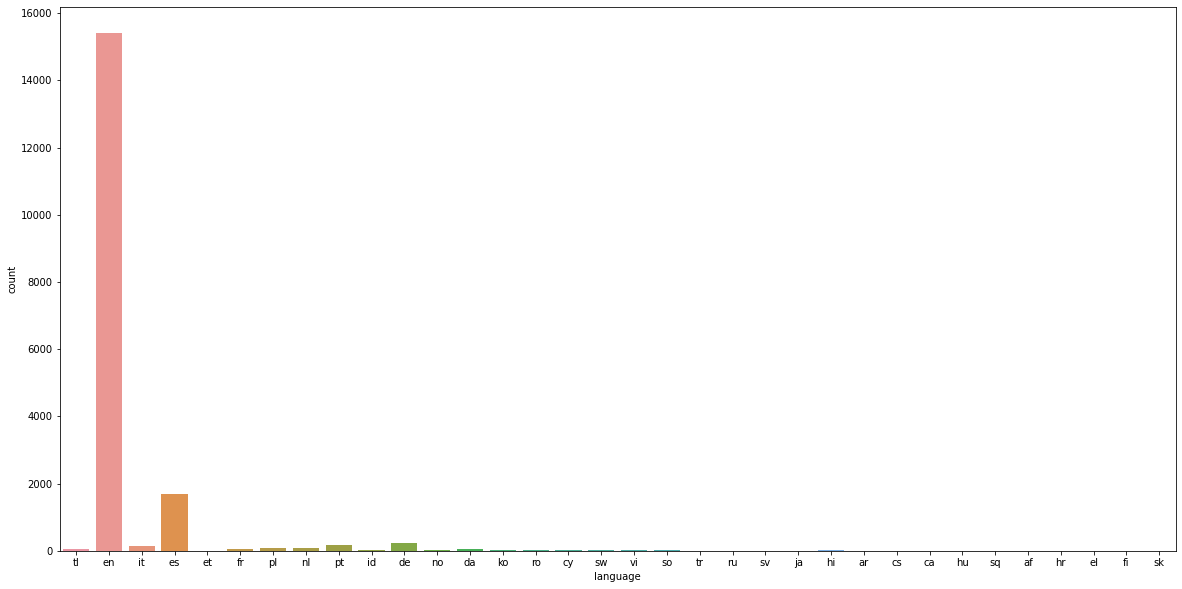

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(20,10))
ax = sns.countplot(x='language', data=df)

In [ ]:
dfen = df[df['language'] == 'en']
dfen['language'].value_counts()

en    15405
Name: language, dtype: int64

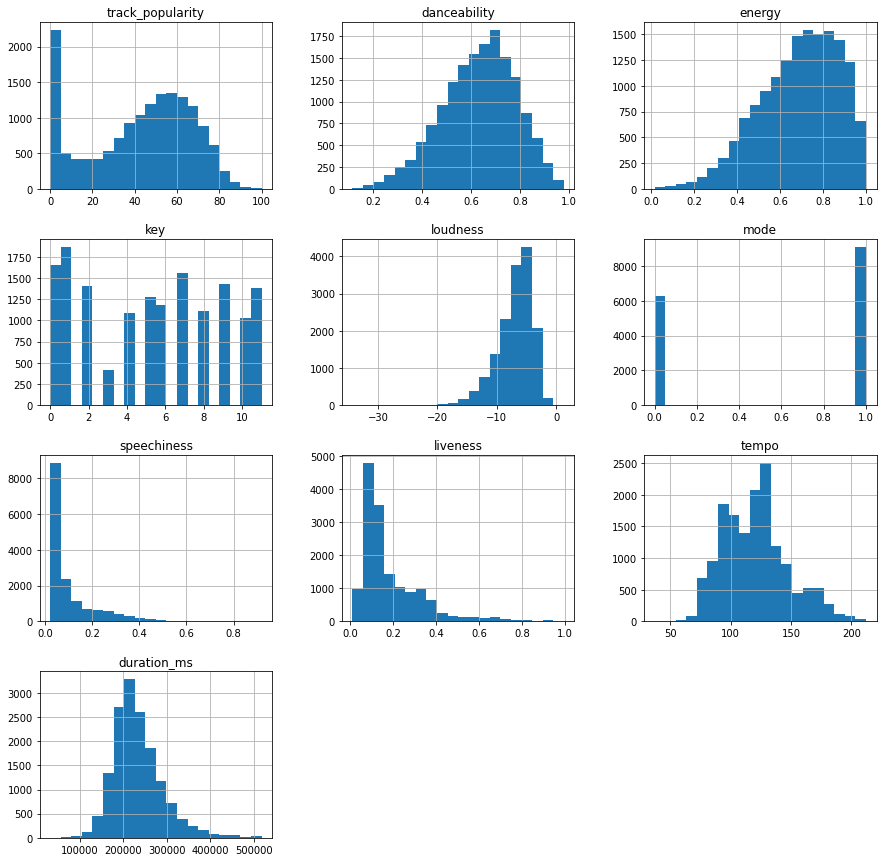

In [ ]:
dfen.hist(figsize = (15,15), bins = 20)
plt.show()

In [ ]:
dfen.isnull().sum()

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(dfen.corr(), annot=True, cmap = 'coolwarm')

In [ ]:
dfen['track_artist'].value_counts().head(10).plot(kind='barh')

In [ ]:
dfen['playlist_subgenre'].value_counts().head(10).plot(kind='barh')

In [ ]:
dfen = dfen.sort_values('track_popularity', ascending = False)
dfen

In [ ]:
plt.figure(figsize=(20,10))
sns.set(style='whitegrid')
x = dfen.groupby('track_artist')['track_popularity'].sum().sort_values(ascending=False).head(10)
ax = sns.barplot(x,x.index)

In [ ]:
dfen.columns

Index(['track_id', 'track_name', 'track_artist', 'lyrics', 'track_popularity',
       'track_album_name', 'track_album_release_date', 'playlist_name',
       'playlist_genre', 'playlist_subgenre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'language'],
      dtype='object')

# DL: слова и настроение



## albert-base-v2-emotion

In [3]:
# импорт предобученной модели

!apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/bhadresh-savani/albert-base-v2-emotion

!ls | awk '{system("rm -rf " $1 "/.git")}'
!ls -Ra

"apt-get" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


Updated git hooks.
Git LFS initialized.


Cloning into 'albert-base-v2-emotion'...
Filtering content:  66% (2/3)
Filtering content:  66% (2/3), 133.82 MiB | 66.45 MiB/s
Filtering content: 100% (3/3), 133.82 MiB | 66.45 MiB/s
Filtering content: 100% (3/3), 133.82 MiB | 5.97 MiB/s, done.
"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [3]:
%pip install torch --upgrade
#==1.11.0+cu113  
#-f https://download.pytorch.org/whl/cu113/torch_stable.html

Note: you may need to restart the kernel to use updated packages.


In [4]:

import tqdm
from collections import Counter
import torch
print('torch   :', torch.__version__)


import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
print('tensorflow   :', tf.__version__)


import random

import matplotlib.pyplot as plt
%matplotlib inline


RANDOM_SEED = 42

torch   : 1.12.1+cpu
tensorflow   : 2.9.1


In [2]:
#'''
#%pip install transformers --upgrade

from transformers import pipeline
from transformers import AutoTokenizer

#tokenizer = AutoTokenizer.from_pretrained('./albert-base-v2-emotion', model_max_len=512)

text_emo_model = pipeline("sentiment-analysis", model='./albert-base-v2-emotion', tokenizer=tokenizer, return_all_scores=True)
text_emo_pred = text_emo_model("I love using transformers. The best part is wide range of support and its easy to use", )
print(text_emo_pred)
#'''

d:\DS\Base\Python310\lib\site-packages\transformers\pipelines\text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


[[{'label': 'sadness', 'score': 0.010403617285192013}, {'label': 'joy', 'score': 0.8902178406715393}, {'label': 'love', 'score': 0.04253280907869339}, {'label': 'anger', 'score': 0.04129810258746147}, {'label': 'fear', 'score': 0.011772056110203266}, {'label': 'surprise', 'score': 0.003775625489652157}]]


In [ ]:
print(dfen.track_artist[2191],  dfen.track_name[2191])

Timmy Trumpet Therapy


In [47]:
# расчет урезания текста: коеф., 
512/649, 1400*0.75

(0.7889060092449923, 1050.0)

In [48]:
turnicate_to = int(1400*0.75)
dfen.lyrics[2191][:turnicate_to]

"I'll be mentally how I'm meant to be Every geek, every freak is a friend to\u2005me Shout\u2005and disagree, be\u2005my enemy Open it up 'cause I\u2005need therapy I-I-I-I, oh-oh-oh, aw, oh I-I-I-I, oh-oh-oh, aw, oh I-eh-I-eh-I, oh-ay-oh, aw-ee-aw Ee-aw-ee, oh I-eh-I-eh-I, oh-ay-oh, aw-ee-aw Ee-aw-ee, oh 'Cause I need therapy I-eh-I-eh-I, oh-ay-oh, aw-ee-aw Ee-aw-ee, oh I-eh-I-eh-I, oh-ay-oh, aw-ee-aw Ee-aw-ee, oh I'll be mentally how I'm meant to be Every geek, every freak is a friend to me Shout and disagree, be my enemy Open it up 'cause I need therapy I-eh-I-eh-I, oh-ay-oh, aw-ee-aw Ee-aw-ee, oh I-oh-aw, oh-I-oh-aw 'Cause I need therapy I-oh-aw, oh-I-oh-aw, oh I'm on my face again High above the world High above the world We're in our space again Crazy boys and girls I'll be mentally how I'm meant to be Every geek, every freak is a friend to\u2005me Shout\u2005and disagree, be\u2005my enemy Open it up 'cause I\u2005need therapy I-I-I-I, oh-oh-oh, aw, oh I-I-I-I, oh-oh-oh, aw, oh I

In [ ]:
len(dfen.lyrics[1])/778

2.9395886889460154

In [ ]:
text_emo_pred = text_emo_model(X_train[:2].to_list())  # .to_list()

In [ ]:
text_emo_pred = text_emo_model(X_train[3])  # .to_list()


In [ ]:
pd.DataFrame.from_dict(text_emo_pred[0]).set_index('label').T#.reset_index()#.drop(index)

label,sadness,joy,love,anger,fear,surprise
score,0.006926,0.015186,0.008188,0.954957,0.013101,0.001643


In [ ]:

text_emos = pd.DataFrame.from_dict(text_emo_pred[0])#.set_index('label').T # , orient='index' columns tight
text_emos



,label,score
0,sadness,0.006926
1,joy,0.015186
2,love,0.008188
3,anger,0.954957
4,fear,0.013101
5,surprise,0.001643


In [ ]:
pd.DataFrame.from_dict(text_emo_model(dfen.lyrics[2191][:1250])[0])

In [4]:

# оставим только English
#%pip install nltk
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

'''
sent = "Io andiamo to the beach with my amico."
" ".join(w for w in nltk.wordpunct_tokenize(sent) \
         if w.lower() in words or not w.isalpha())

'''
dfen.lyrics.apply(lambda x: " ".join(w for w in nltk.wordpunct_tokenize(x) \
         if w.lower() in words or not w.isalpha()))

'''
lyrics_clean = pd.Series()

for row_value in dfen.lyrics.iteritems():
    lyrics_clean.append(pd.Series(" ".join(w for w in nltk.wordpunct_tokenize(row_value[1]) \
         if w.lower() in words or not w.isalpha())), inplace=True)
'''


[nltk_data] Downloading package words to
[nltk_data]     C:\Users\AK\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


'\nlyrics_clean = pd.Series()\n\nfor row_value in dfen.lyrics.iteritems():\n    lyrics_clean.append(pd.Series(" ".join(w for w in nltk.wordpunct_tokenize(row_value[1])          if w.lower() in words or not w.isalpha())), inplace=True)\n'

In [ ]:
# Сработало!

text_emos = pd.DataFrame()
for row_value in dfen.lyrics.iteritems():
    try:
        text_emo_pred = text_emo_model(row_value[1][:1400])[0]
    except:
        try:
            text_emo_pred = text_emo_model(row_value[1][:1200])[0]
            print(row_value[0], 'turnikated')
        except:
            text_emo_pred = text_emo_model(row_value[1][:700])[0]
            print(row_value[0], 'turnikated')

    text_emos = text_emos.append(pd.DataFrame.from_dict(text_emo_pred).set_index('label').T)  #.set_index(row_value[0])
    #display(pd.DataFrame.from_dict(text_emo_model(row_value[1][:1300])[0]).set_index('label').T)  #.set_index('label').T

text_emos.reset_index(drop=True, inplace=True)
print(len(text_emos), 'lines')
text_emos

In [37]:
text_emos.reset_index(drop=True, inplace=True)

In [6]:
# Сохранение готовых предсказаний (на комп)
text_emos.to_csv('text_emos.csv')

#from google.colab import files 
#files.download('text_emos.csv')

In [50]:
## Загрузка готовых предсказаний
text_emos = pd.read_csv('text_emos.csv', index_col=0)

In [7]:
len(text_emos)

15405

In [8]:
# Средние значения по эмоциям
text_emos.mean().sort_values(ascending=False)

label
anger       0.376202
joy         0.287047
sadness     0.151538
love        0.112190
fear        0.062598
surprise    0.010425
dtype: float64

## Aniemore/Russian-Emotion-Recognition

In [11]:
!apt-get install git-lfs
!git lfs install

!git clone https://huggingface.co/spaces/Aniemore/Russian-Emotion-Recognition
#!git clone https://huggingface.co/Aniemore/wav2vec2-xlsr-53-russian-emotion-recognition


!ls | awk '{system("rm -rf " $1 "/.git")}'
!ls -Ra

"apt-get" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


Updated git hooks.
Git LFS initialized.


Cloning into 'Russian-Emotion-Recognition'...
"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"ls" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer

#tokenizer = AutoTokenizer.from_pretrained('./albert-base-v2-emotion', model_max_len=512)

# sound_emo_model = pipeline("audio-classification", model='Aniemore/Russian-Emotion-Recognition', return_all_scores=True, trust_remote_code=True) # , tokenizer=tokenizer
sound_emo_model = pipeline("audio-classification", model='./Russian-Emotion-Recognition', return_all_scores=True, trust_remote_code=True) # , tokenizer=tokenizer

#sound_emo_pred = sound_emo_model('D:\DNS\Downloads\mus_list\76LIYXBETh3PyHoNUufycb.wav')
sound_emo_pred = sound_emo_model('76LIYXBETh3PyHoNUufycb.wav')

print(sound_emo_pred)
#''' Aniemore/Russian-Emotion-Recognition    ./Russian-Emotion-Recognition

In [1]:
#'''
# работает неправильно
#%pip install transformers

from transformers import pipeline
from transformers import AutoTokenizer

#tokenizer = AutoTokenizer.from_pretrained('./albert-base-v2-emotion', model_max_len=512)

sound_emo_model = pipeline("audio-classification", model='./wav2vec2-xlsr-53-russian-emotion-recognition', return_all_scores=True, trust_remote_code=True) # , tokenizer=tokenizer

#sound_emo_pred = sound_emo_model('D:\DNS\Downloads\mus_list\76LIYXBETh3PyHoNUufycb.wav')
sound_emo_pred = sound_emo_model('76LIYXBETh3PyHoNUufycb.wav')

print(sound_emo_pred)
#'''

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Some weights of the model checkpoint at ./wav2vec2-xlsr-53-russian-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initia

[{'score': 0.15070848166942596, 'label': 'happiness'}, {'score': 0.14750248193740845, 'label': 'sadness'}, {'score': 0.14583691954612732, 'label': 'disgust'}, {'score': 0.14366145431995392, 'label': 'anger'}, {'score': 0.14198875427246094, 'label': 'neutral'}]


In [21]:
#%pip install numpy==1.21
#numpy.__version__

     ---------------------------------------- 10.3/10.3 MB 8.4 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'D:\\DS\\Base\\Python310\\Lib\\site-packages\\~-mpy\\.libs\\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.



'1.23.2'

  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for numpy: filename=numpy-1.21.0-cp310-cp310-win_amd64.whl size=5472097 sha256=1bc51106200fd4519780b63139c60243c5f11d3d9afea8a1d442fb5133aea61c
  Stored in directory: c:\users\ak\appdata\local\pip\cache\wheels\05\61\d1\ccc2cd557b39e127ad98a392d9558f3c5dda28764b7f54b2f5
Successfully built numpy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.2
    Uninstalling numpy-1.23.2:
      Successfully uninstalled numpy-1.23.2


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from transformers import AutoConfig, AutoModel, Wav2Vec2FeatureExtractor

import librosa
#pip install numpy==1.21
#pip cache list
import numpy as np


def speech_file_to_array_fn(path, sampling_rate):
    speech_array, _sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    return speech


def predict(path, sampling_rate):
    speech = speech_file_to_array_fn(path, sampling_rate)
    inputs = feature_extractor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)
    inputs = {key: inputs[key].to(device) for key in inputs}

    with torch.no_grad():
        logits = model_(**inputs).logits

    scores = F.softmax(logits, dim=1).detach().cpu().numpy()[0]
    outputs = [{"Emotion": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return outputs

In [5]:
from transformers import AutoConfig, AutoModel, Wav2Vec2FeatureExtractor
import torch

TRUST = True

config = AutoConfig.from_pretrained('Aniemore/wav2vec2-xlsr-53-russian-emotion-recognition', trust_remote_code=TRUST)
model_ = AutoModel.from_pretrained("Aniemore/wav2vec2-xlsr-53-russian-emotion-recognition", trust_remote_code=TRUST)
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("Aniemore/wav2vec2-xlsr-53-russian-emotion-recognition")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_.to(device)

Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a configuration with custom code to ensure no malicious code has been contributed in a newer revision.
Explicitly passing a `revision` is encouraged when loading a model with custom code to ensure no malicious code has been contributed in a newer revision.


Wav2Vec2ForSpeechClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), 

In [7]:
model_.predict('76LIYXBETh3PyHoNUufycb.wav', 11025)

AttributeError: 'Wav2Vec2ForSpeechClassification' object has no attribute 'predict'

In [13]:
#sound_emo_pred = sound_emo_model('D:\DNS\Downloads\mus_list\76LIYXBETh3PyHoNUufycb.wav')
sound_emo_pred = sound_emo_model('76LIYXBETh3PyHoNUufycb.wav')
print(sound_emo_pred)

[{'score': 0.1635141521692276, 'label': 'disgust'}, {'score': 0.14761649072170258, 'label': 'sadness'}, {'score': 0.1456233561038971, 'label': 'fear'}, {'score': 0.1441740095615387, 'label': 'anger'}, {'score': 0.14251433312892914, 'label': 'happiness'}]


In [14]:
pd.DataFrame.from_dict(sound_emo_pred).set_index('label').T.reset_index(drop=True)

label,disgust,sadness,fear,anger,happiness
0,0.163514,0.147616,0.145623,0.144174,0.142514


##### sound_emos (очистка и обзор)
Полный микс песни (от 40-й до 100-й секунды)

In [81]:
import pandas as pd
sound_emos = pd.read_csv('sound_emos.csv', index_col=0) # , engine='python'
sound_emos.head(3)

,anger,disgust,enthusiasm,fear,happiness,neutral,sadness,track_id
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0Vqap6DWhvILPwGvbtlUi5
1,1.6,0.7,0.0,0.0,0.0,0.0,97.6,3U7fJ0VfFR1Msntjgd3DPB
2,0.0,0.0,0.0,0.0,0.0,0.0,100.0,6fOOKqQWcSy33ApU1wqkkW


In [82]:
'''
# Преобразуем проценты в доли, сохраняем
sound_emos = pd.concat([(sound_emos.drop(['track_id'], axis=1)/100), sound_emos.track_id], axis =1)
sound_emos.head(3)
#sound_emos.to_csv('sound_emos.csv')

,anger,disgust,enthusiasm,fear,happiness,neutral,sadness,track_id
0,1.000,0.000,0.0,0.0,0.0,0.0,0.000,0Vqap6DWhvILPwGvbtlUi5
1,0.016,0.007,0.0,0.0,0.0,0.0,0.976,3U7fJ0VfFR1Msntjgd3DPB
2,0.000,0.000,0.0,0.0,0.0,0.0,1.000,6fOOKqQWcSy33ApU1wqkkW


In [ ]:
'''
# Очищаем от "%"
for col in sound_emos.columns[:-1]:
    sound_emos[col] = pd.to_numeric(sound_emos[col].str.strip('%'))

sound_emos
'''

In [59]:
sound_emos.drop(['track_id'], axis=1).describe().iloc[1:-1].style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1)  #.iloc[1:-1] № axis=1  None

,anger,disgust,enthusiasm,fear,happiness,neutral,sadness
mean,18.598000,4.696333,0.000333,1.398667,3.343667,13.827667,58.112000
std,37.417501,19.391724,0.005774,11.411618,16.525873,33.897728,48.350815
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,99.250000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000


array([[<AxesSubplot:title={'center':'anger'}>,
        <AxesSubplot:title={'center':'disgust'}>,
        <AxesSubplot:title={'center':'enthusiasm'}>],
       [<AxesSubplot:title={'center':'fear'}>,
        <AxesSubplot:title={'center':'happiness'}>,
        <AxesSubplot:title={'center':'neutral'}>],
       [<AxesSubplot:title={'center':'sadness'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

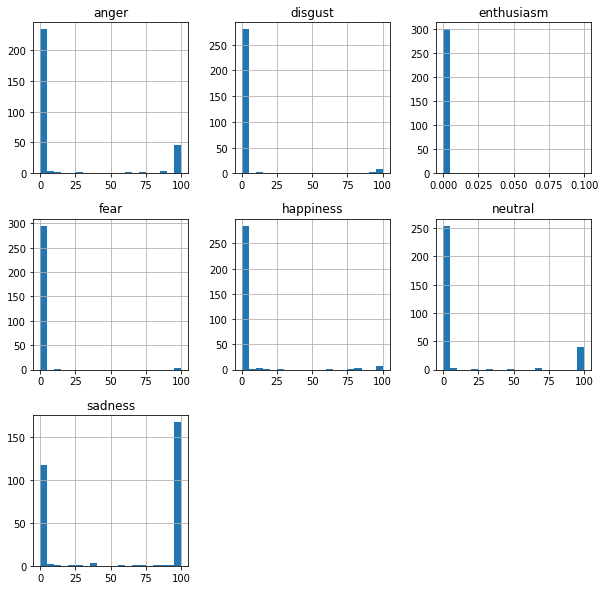

In [37]:
sound_emos.drop(['track_id'], axis=1).hist(bins=20, figsize=[10,10])

##### voice_emos
Голосовая партия песни (от 40-й до 100-й секунды)

In [79]:

import pandas as pd
voice_emos = pd.read_csv('voice_emos.csv', index_col=0) # , engine='python'
voice_emos.head(3)

,anger,disgust,enthusiasm,fear,happiness,neutral,sadness,track_id
0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0Vqap6DWhvILPwGvbtlUi5
1,100.0,0.0,0.0,0.0,0.0,0.0,0.0,3U7fJ0VfFR1Msntjgd3DPB
2,7.7,89.0,0.0,0.2,0.0,0.0,3.0,6fOOKqQWcSy33ApU1wqkkW


In [80]:
'''
# Преобразуем проценты в доли, сохраняем
voice_emos = pd.concat([(voice_emos.drop(['track_id'], axis=1)/100), voice_emos.track_id], axis =1)
voice_emos.head(3)
#voice_emos.to_csv('voice_emos.csv')
'''

,anger,disgust,enthusiasm,fear,happiness,neutral,sadness,track_id
0,1.000,0.00,0.0,0.000,0.0,0.0,0.00,0Vqap6DWhvILPwGvbtlUi5
1,1.000,0.00,0.0,0.000,0.0,0.0,0.00,3U7fJ0VfFR1Msntjgd3DPB
2,0.077,0.89,0.0,0.002,0.0,0.0,0.03,6fOOKqQWcSy33ApU1wqkkW


In [84]:
voice_emos.to_csv('voice_emos.csv')

In [60]:
voice_emos.drop(['track_id'], axis=1).describe().iloc[1:-1].style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1)#.iloc[1:-1]


,anger,disgust,enthusiasm,fear,happiness,neutral,sadness
mean,35.485000,14.300333,0.130667,0.416333,12.383667,1.083333,36.173000
std,44.773522,31.185557,2.257428,4.209072,30.924757,9.463805,44.291727
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.700000,0.000000,0.000000,0.000000,0.000000,0.000000,3.650000
75%,97.750000,1.625000,0.000000,0.200000,0.525000,0.000000,98.575000


array([[<AxesSubplot:title={'center':'anger'}>,
        <AxesSubplot:title={'center':'disgust'}>,
        <AxesSubplot:title={'center':'enthusiasm'}>],
       [<AxesSubplot:title={'center':'fear'}>,
        <AxesSubplot:title={'center':'happiness'}>,
        <AxesSubplot:title={'center':'neutral'}>],
       [<AxesSubplot:title={'center':'sadness'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

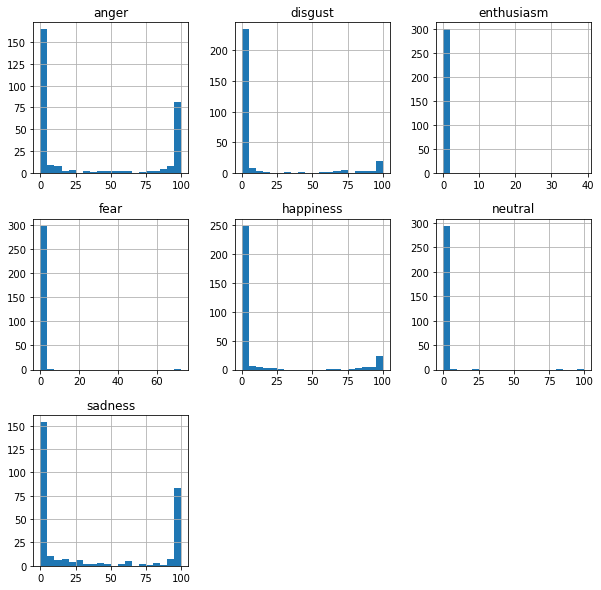

In [46]:
voice_emos.drop(['track_id'], axis=1).hist(bins=20, figsize=[10,10])


#### Усреднение sound_emos и voice_emos

In [85]:

sound_emos = pd.read_csv('sound_emos.csv', index_col=0)
voice_emos = pd.read_csv('voice_emos.csv', index_col=0)

display(sound_emos.head(3))
display(voice_emos.head(3))

,anger,disgust,enthusiasm,fear,happiness,neutral,sadness,track_id
0,1.000,0.000,0.0,0.0,0.0,0.0,0.000,0Vqap6DWhvILPwGvbtlUi5
1,0.016,0.007,0.0,0.0,0.0,0.0,0.976,3U7fJ0VfFR1Msntjgd3DPB
2,0.000,0.000,0.0,0.0,0.0,0.0,1.000,6fOOKqQWcSy33ApU1wqkkW


,anger,disgust,enthusiasm,fear,happiness,neutral,sadness,track_id
0,1.000,0.00,0.0,0.000,0.0,0.0,0.00,0Vqap6DWhvILPwGvbtlUi5
1,1.000,0.00,0.0,0.000,0.0,0.0,0.00,3U7fJ0VfFR1Msntjgd3DPB
2,0.077,0.89,0.0,0.002,0.0,0.0,0.03,6fOOKqQWcSy33ApU1wqkkW


array([[<AxesSubplot:title={'center':'anger'}>,
        <AxesSubplot:title={'center':'disgust'}>,
        <AxesSubplot:title={'center':'enthusiasm'}>],
       [<AxesSubplot:title={'center':'fear'}>,
        <AxesSubplot:title={'center':'happiness'}>,
        <AxesSubplot:title={'center':'neutral'}>],
       [<AxesSubplot:title={'center':'sadness'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

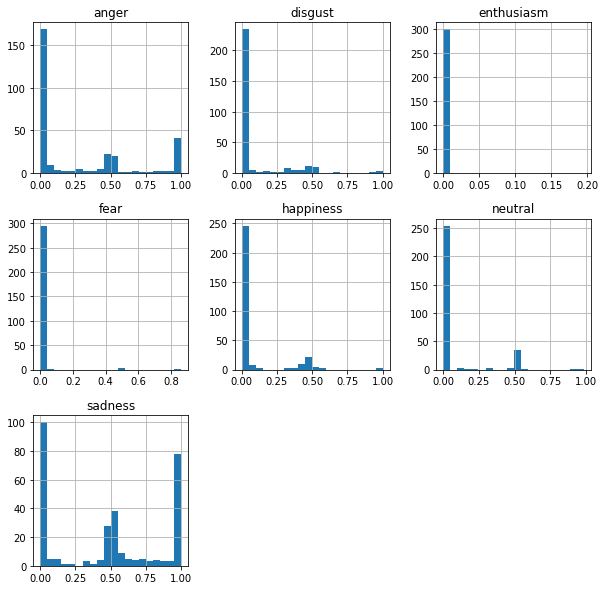

In [91]:
# При усреднении значений сетов эмоций добъемся меньшей бинарности, 
# а значит -- большей вариативности, что при обучении главной обобщающей модели может положительнло сказаться на сходимости,
# т.к. признаки таргета достаточно вариативны.

sound_voice_emos = (sound_emos.drop(['track_id'], axis=1) + voice_emos.drop(['track_id'], axis=1))/2
sound_voice_emos.hist(bins=20, figsize=[10,10])

# Или -- не скажется...
# Но зато здесь увидим, в каких эмоциях модель их определения дает разные показания на песне и на голосе.
# Это заметно по скоплению значений около 0.5.

In [97]:
# Вернем track_id на место
sound_voice_emos = pd.concat([sound_voice_emos, voice_emos.track_id], axis =1)
sound_voice_emos

In [99]:
#sound_voice_emos.to_csv('sound_voice_emos.csv')

### Объединение text_emos и sound_emos

In [3]:
import pandas as pd

Xy_clust = pd.read_csv('Xy_clust.csv', index_col=0)
Xy_clust.head(3)


,track_name,track_artist,track_id,sadness,joy,love,anger,fear,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
0,I Feel Alive,Steady Rollin,004s3t0ONYlzxII9PLgU6z,0.018201,0.948715,0.028581,0.002713,0.000765,0.001025,1,0.216686,0.877962,1.0,0.011793,0.407663,0.560561,0
1,Poison,Bell Biv DeVoe,00chLpzhgVjxs1zKC9UScL,0.029140,0.113049,0.012400,0.154020,0.647866,0.043525,5,0.844728,0.646090,0.0,0.004353,0.655900,0.427315,3
2,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,00cqd6ZsSkLZqGMlQCR0Zo,0.006108,0.009433,0.006450,0.965541,0.011138,0.001330,0,0.358053,0.367436,0.0,0.694556,0.408672,0.465533,4


In [102]:
# (эмоции песни + эмоции голоса)/2
sound_voice_emos = pd.read_csv('sound_voice_emos.csv', index_col=0)
sound_voice_emos.head(3)

,anger,disgust,enthusiasm,fear,happiness,neutral,sadness,track_id
0,1.0000,0.0000,0.0,0.000,0.0,0.0,0.000,0Vqap6DWhvILPwGvbtlUi5
1,0.5080,0.0035,0.0,0.000,0.0,0.0,0.488,3U7fJ0VfFR1Msntjgd3DPB
2,0.0385,0.4450,0.0,0.001,0.0,0.0,0.515,6fOOKqQWcSy33ApU1wqkkW


#### Обединяем эмоции песни и текста

In [2]:
# эмоции песни (без отдельных эмоций голоса)
sound_emos = pd.read_csv('sound_emos.csv', index_col=0)
sound_emos.head(3)

,anger,disgust,enthusiasm,fear,happiness,neutral,sadness,track_id
0,1.000,0.000,0.0,0.0,0.0,0.0,0.000,0Vqap6DWhvILPwGvbtlUi5
1,0.016,0.007,0.0,0.0,0.0,0.0,0.976,3U7fJ0VfFR1Msntjgd3DPB
2,0.000,0.000,0.0,0.0,0.0,0.0,1.000,6fOOKqQWcSy33ApU1wqkkW


In [13]:
# Обединяем эмоции песни (без отдельных эмоций голоса) и текста

text_sound_emo__Xy_clust = sound_emos.merge(Xy_clust, on='track_id')
text_sound_emo__Xy_clust.to_csv('text_sound_emo__Xy_clust.csv')
text_sound_emo__Xy_clust.head(3)

,anger_x,disgust,enthusiasm,fear_x,happiness,neutral,sadness_x,track_id,track_name,track_artist,...,fear_y,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
0,1.000,0.000,0.0,0.0,0.0,0.0,0.000,0Vqap6DWhvILPwGvbtlUi5,The Rhythm,Kwame,...,0.009749,0.006151,1,0.940904,0.440659,0.0,0.796371,0.916245,0.358376,4
1,0.016,0.007,0.0,0.0,0.0,0.0,0.976,3U7fJ0VfFR1Msntjgd3DPB,You Really Got a Hold on Me,She & Him,...,0.014118,0.003657,4,0.297798,0.031221,1.0,0.968750,0.155390,0.215709,5
2,0.000,0.000,0.0,0.0,0.0,0.0,1.000,6fOOKqQWcSy33ApU1wqkkW,Paradise,Khalid,...,0.053450,0.006545,3,0.538818,0.442693,1.0,0.207660,0.527745,0.216726,1


#### Обединяем эмоции голоса и текста

In [5]:
voice_emos = pd.read_csv('voice_emos.csv', index_col=0)
voice_emos.head(3)


,anger,disgust,enthusiasm,fear,happiness,neutral,sadness,track_id
0,1.000,0.00,0.0,0.000,0.0,0.0,0.00,0Vqap6DWhvILPwGvbtlUi5
1,1.000,0.00,0.0,0.000,0.0,0.0,0.00,3U7fJ0VfFR1Msntjgd3DPB
2,0.077,0.89,0.0,0.002,0.0,0.0,0.03,6fOOKqQWcSy33ApU1wqkkW


In [6]:
text_voice_emo__Xy_clust = voice_emos.merge(Xy_clust, on='track_id')
text_voice_emo__Xy_clust.to_csv('text_voice_emo__Xy_clust.csv')
text_voice_emo__Xy_clust.head(3)


,anger_x,disgust,enthusiasm,fear_x,happiness,neutral,sadness_x,track_id,track_name,track_artist,...,fear_y,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
0,1.000,0.00,0.0,0.000,0.0,0.0,0.00,0Vqap6DWhvILPwGvbtlUi5,The Rhythm,Kwame,...,0.009749,0.006151,1,0.940904,0.440659,0.0,0.796371,0.916245,0.358376,4
1,1.000,0.00,0.0,0.000,0.0,0.0,0.00,3U7fJ0VfFR1Msntjgd3DPB,You Really Got a Hold on Me,She & Him,...,0.014118,0.003657,4,0.297798,0.031221,1.0,0.968750,0.155390,0.215709,5
2,0.077,0.89,0.0,0.002,0.0,0.0,0.03,6fOOKqQWcSy33ApU1wqkkW,Paradise,Khalid,...,0.053450,0.006545,3,0.538818,0.442693,1.0,0.207660,0.527745,0.216726,1


In [7]:
text_voice_emo__Xy_clust.to_csv('text_voice_emo__Xy_clust.csv')

#### Обединяем все эмоции звука (песня+голос) и текста

In [188]:
# Обединяем все эмоции звука и текста

text_all_sound_emo__Xy_clust = sound_voice_emos.merge(Xy_clust, on='track_id')
text_all_sound_emo__Xy_clust.head(3)

,anger_x,disgust,enthusiasm,fear_x,happiness,neutral,sadness_x,track_id,track_name,track_artist,...,fear_y,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
0,1.0000,0.0000,0.0,0.000,0.0,0.0,0.000,0Vqap6DWhvILPwGvbtlUi5,The Rhythm,Kwame,...,0.009749,0.006151,1,0.940904,0.440659,0.0,0.796371,0.916245,0.358376,4
1,0.5080,0.0035,0.0,0.000,0.0,0.0,0.488,3U7fJ0VfFR1Msntjgd3DPB,You Really Got a Hold on Me,She & Him,...,0.014118,0.003657,4,0.297798,0.031221,1.0,0.968750,0.155390,0.215709,5
2,0.0385,0.4450,0.0,0.001,0.0,0.0,0.515,6fOOKqQWcSy33ApU1wqkkW,Paradise,Khalid,...,0.053450,0.006545,3,0.538818,0.442693,1.0,0.207660,0.527745,0.216726,1


In [189]:
text_all_sound_emo__Xy_clust.groupby(['label_y']).mean().style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1)

,anger_x,disgust,enthusiasm,fear_x,happiness,neutral,sadness_x,sadness_y,joy,love,anger_y,fear_y,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo
label_y,,,,,,,,,,,,,,,,,,,,
0,0.229800,0.074740,0.000000,0.011030,0.108220,0.157400,0.418560,0.182463,0.276758,0.169754,0.278959,0.087480,0.004585,2.140000,0.504705,0.736703,1.000000,0.082588,0.354855,0.513955
1,0.436750,0.075010,0.000000,0.001560,0.094310,0.062140,0.329940,0.093806,0.303650,0.084146,0.453829,0.040193,0.024376,1.320000,0.663569,0.737903,1.000000,0.114985,0.712772,0.435893
2,0.248830,0.085070,0.000010,0.011960,0.085740,0.135540,0.432490,0.252441,0.281112,0.054792,0.383499,0.024317,0.003839,1.520000,0.514345,0.737191,0.000000,0.048993,0.351773,0.522367
3,0.282870,0.060670,0.000000,0.001240,0.075740,0.055560,0.523660,0.117240,0.266235,0.169762,0.379435,0.062482,0.004846,1.740000,0.703940,0.751795,0.000000,0.122214,0.742682,0.444072
4,0.245780,0.136940,0.003920,0.018130,0.074590,0.026680,0.493770,0.167149,0.329807,0.147814,0.273649,0.076751,0.004829,2.080000,0.580371,0.462707,0.000000,0.504818,0.440541,0.434419
5,0.178460,0.137470,0.000000,0.010530,0.033220,0.010010,0.630130,0.149580,0.312811,0.141965,0.329773,0.060348,0.005523,1.760000,0.535411,0.436274,1.000000,0.593387,0.399045,0.465753


In [190]:
text_all_sound_emo__Xy_clust.corr().style.background_gradient(cmap="coolwarm", axis=None, vmin=-1, vmax=1)


,anger_x,disgust,enthusiasm,fear_x,happiness,neutral,sadness_x,sadness_y,joy,love,anger_y,fear_y,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
anger_x,1.000000,-0.185811,-0.042788,-0.082276,-0.204263,-0.179674,-0.630560,-0.124177,-0.024607,-0.057996,0.202964,-0.064821,-0.039116,-0.156785,0.255990,0.180690,0.030766,-0.103775,0.183584,-0.146125,-0.106117
disgust,-0.185811,1.000000,-0.026499,0.001636,-0.181708,-0.151015,-0.188441,-0.010805,0.087414,0.061646,-0.096591,-0.030579,-0.034636,0.029309,-0.062018,-0.182514,0.003700,0.111178,-0.127459,0.000910,0.113358
enthusiasm,-0.042788,-0.026499,1.000000,-0.007534,0.020387,0.149863,-0.052535,-0.023601,-0.022922,0.078137,-0.004589,-0.012816,-0.004051,0.047710,-0.019254,-0.099089,-0.058128,0.099354,-0.012290,0.019722,0.050881
fear_x,-0.082276,0.001636,-0.007534,1.000000,0.019782,-0.044975,-0.089415,0.141956,-0.023612,-0.056011,-0.044460,-0.031659,-0.009244,0.024727,-0.093152,-0.043664,-0.019562,0.008280,-0.089790,0.131368,0.025455
happiness,-0.204263,-0.181708,0.020387,0.019782,1.000000,0.276302,-0.317038,0.084121,-0.029742,-0.008578,-0.059598,0.004942,0.122756,0.006774,-0.189622,0.169157,-0.000287,-0.072259,0.031739,0.007764,-0.116673
neutral,-0.179674,-0.151015,0.149863,-0.044975,0.276302,1.000000,-0.342693,-0.026482,0.073426,-0.109205,-0.026595,0.068878,0.135492,-0.042257,-0.323736,0.284349,0.010720,-0.240738,-0.005667,0.092036,-0.246212
sadness_x,-0.630560,-0.188441,-0.052535,-0.089415,-0.317038,-0.342693,1.000000,0.068282,-0.037406,0.083617,-0.088955,0.047216,-0.064105,0.139684,0.050996,-0.271852,-0.029876,0.178626,-0.099452,0.064298,0.201277
sadness_y,-0.124177,-0.010805,-0.023601,0.141956,0.084121,-0.026482,0.068282,1.000000,-0.332694,-0.227284,-0.313902,-0.123537,-0.050655,0.123938,-0.156024,0.006677,-0.064222,-0.062737,-0.090436,-0.029890,-0.013483
joy,-0.024607,0.087414,-0.022922,-0.023612,-0.029742,0.073426,-0.037406,-0.332694,1.000000,-0.069509,-0.512466,-0.235495,-0.048280,-0.125841,-0.052657,-0.027738,0.008264,0.052535,-0.007231,-0.032649,0.036727
love,-0.057996,0.061646,0.078137,-0.056011,-0.008578,-0.109205,0.083617,-0.227284,-0.069509,1.000000,-0.342179,-0.153317,-0.040087,0.502787,0.049380,-0.131598,0.017062,0.117946,-0.036292,0.002256,0.035509


In [191]:
text_all_sound_emo__Xy_clust.to_csv('text_all_sound_emo__Xy_clust.csv')


### Токенизация 

In [5]:
# pip install tensorflow
# pip install torch

     -------------------------------------- 444.1/444.1 MB 2.7 MB/s eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 5.8/5.8 MB 6.1 MB/s eta 0:00:00
     -------------------------------------- 895.5/895.5 kB 9.4 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 10.3 MB/s eta 0:00:00
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     --------------------------------------- 14.2/14.2 MB 10.1 MB/s eta 0:00:00
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
     ---------------------------------------- 3.5/3.5 MB 10.8 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 5.1 MB/s eta 0:00:00
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
     --


[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
pip install torch

     -------------------------------------- 162.2/162.2 MB 4.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 22.2.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:

import tqdm
from collections import Counter
import torch
print('torch   :', torch.__version__)


import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
print('tensorflow   :', tf.__version__)


import random

import matplotlib.pyplot as plt
%matplotlib inline


RANDOM_SEED = 42

torch   : 1.12.1+cpu
tensorflow   : 2.9.1


In [ ]:
'''
# https://huggingface.co/docs/transformers/v4.15.0/en/model_doc/albert#transformers.AlbertConfig
from transformers import AlbertTokenizer # AlbertTokenizer  AlbertTokenizerFast

MODEL_DIR = "./albert-base-v2-emotion"
#MODEL_DIR = "albert-base-v2-emotion"



tokenizer = AlbertTokenizer.from_pretrained(MODEL_DIR)
emo_model = AutoModel.from_pretrained(MODEL_DIR) # , from_tf=True

device = "cuda:0"

emo_model  = emo_model.to(device)
'''

In [ ]:
#%pip install transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# а вдруг заработает?
#from transformers import BertTokenizer
#from transformers import AutoTokenizer, AutoModel



MODEL_DIR = "./albert-base-v2-emotion"
#MODEL_DIR = "albert-base-v2-emotion"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, truncating = True)

sbert_model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
#sbert_model = AutoModel.from_pretrained(MODEL_DIR)

#device = "cuda:0"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

sbert_model  = sbert_model.to(device)


def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

 

def get_embeddings(sentences, model, device):
    encoded_input = tokenizer.encode_plus(sentences, padding=True, truncation=True, return_tensors='pt').to(device)

     # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

     # Perform pooling. In this case, max pooling.
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings


def iterate_minibatches(x, batch_size=128):
    N = len(x)
    left = 0
    right = batch_size
    while right < N:
        yield x[left:right]
        left += batch_size
        right += batch_size
    yield x[left:]


def df_to_emb(train_data):
    all_res = []
    for i in tqdm.tqdm(iterate_minibatches(list(train_data.values), batch_size=1)): # train_data['description'].values
        emb = get_embeddings(i, sbert_model, device).cpu().data.numpy()
        all_res.append(emb)
    return pd.DataFrame(np.vstack(all_res))

Some weights of the model checkpoint at ./albert-base-v2-emotion were not used when initializing AlbertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:


#Get embeddings:
#train_emb = df_to_emb(data_sbert.description.iloc[X_train.index])
train_emo = df_to_emb(X_train.copy()) # .iloc[X_train.index]   .values.tolist()

valid_emo = df_to_emb(X_test.copy()) # .iloc[X_test.index]
#test_emb = df_to_emb(data_sbert.lyrics.iloc[X_sub.index])

train_emo.shape, valid_emb.shape, #test_emb.shape

0it [00:00, ?it/s]


TypeError: ignored

# Split

### text_emo на mus_feats

In [245]:
dfen.playlist_subgenre.unique()

array(['hard rock', 'new jack swing', 'neo soul', 'dance pop',
       'urban contemporary', 'big room', 'indie poptimism',
       'gangster rap', 'album rock', 'hip pop', 'post-teen pop', 'trap',
       'southern hip hop', 'electropop', 'tropical',
       'progressive electro house', 'pop edm', 'latin hip hop', 'hip hop',
       'permanent wave', 'classic rock', 'electro house', 'latin pop',
       'reggaeton'], dtype=object)

In [39]:
'''
# Теперь выделим тестовую часть
#train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
#test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)
'''

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import random

RANDOM_SEED = 42

## Загрузка готовых предсказаний эмоций
text_emos = pd.read_csv('text_emos.csv', index_col=[0])


# Label Encoding
columns_cat = ['playlist_subgenre'] # playlist_genre  playlist_subgenre

#for column in columns_cat:
#    dfen[column] = dfen[column].astype('category').cat.codes
    
# One-Hot Encoding: в pandas есть готовая функция - get_dummies.
#dfen_cat = pd.get_dummies(dfen[columns_cat], columns=columns_cat, dummy_na=False)


#X = dfen.lyrics   
X = text_emos   

# избранные колонки
columns_neuro = ['danceability', 'energy', 'mode', 'acousticness', 'valence']  # , 'tempo' 
columns_num = ['danceability', 'energy', 'mode', 'acousticness', 'valence', 'tempo']  # , 'tempo' 

#y = dfen[columns_neuro]
# убрал   , 'loudness', 'speechiness', 'instrumentalness', 'liveness'

# или нормализуем
scaler = MinMaxScaler()
#scaler = RobustScaler()

y = pd.DataFrame(scaler.fit_transform(dfen[columns_num]), columns=columns_num)

# С категориальными признаками
#y = pd.concat((pd.DataFrame(scaler.fit_transform(dfen[columns_num]), columns=columns_num), dfen_cat), axis=1)

#X = df.drop(['lyrics'], axis=1)



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

display(X_train.sample(1))
display(y_test.sample(1))


,sadness,joy,love,anger,fear,surprise
14964,0.007093,0.980904,0.006284,0.002998,0.001239,0.001482


,danceability,energy,mode,acousticness,valence,tempo
11184,0.359212,0.958304,1.0,0.000053,0.375372,0.673603


In [15]:
# Для просто EMO
train_emb = X_train
valid_emb = X_test

### text_sound_emo в разных вариациях


In [14]:
voice_emos = pd.read_csv('voice_emos.csv', index_col=0)
text_sound_emo__Xy_clust = pd.read_csv('text_sound_emo__Xy_clust.csv', index_col=0)
text_voice_emo__Xy_clust = pd.read_csv('text_voice_emo__Xy_clust.csv', index_col=0)
text_all_sound_emo__Xy_clust = pd.read_csv('text_all_sound_emo__Xy_clust.csv', index_col=0)


In [116]:
text_sound_emo__Xy_clust.columns

Index(['anger_x', 'disgust', 'enthusiasm', 'fear_x', 'happiness', 'neutral',
       'sadness_x', 'track_id', 'track_name', 'track_artist', 'sadness_y',
       'joy', 'love', 'anger_y', 'fear_y', 'surprise', 'label_X',
       'danceability', 'energy', 'mode', 'acousticness', 'valence', 'tempo',
       'label_y'],
      dtype='object')

In [26]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import random

RANDOM_SEED = 42

## Загрузка и отбор готовых предсказаний эмоций
# text_all_sound_emo__Xy_clust = pd.read_csv('text_all_sound_emo__Xy_clust.csv', index_col=[0])



# Смесь всех эмоций звука и текста    --> MAPE 24.8 (обучение на кластеры музыкальных признаков)
# X = text_all_sound_emo__Xy_clust[['anger_x', 'disgust', 'enthusiasm', 'fear_x', 'happiness', 'neutral',
#                         'sadness_x', 'sadness_y', 'joy', 'love', 'anger_y', 'fear_y', 'surprise']]

# Смесь всех эмоций звука и не конкурирующих эмоций текста    --> MAPE 24.2 !!!
# X = text_all_sound_emo__Xy_clust[['anger_x', 'disgust', 'enthusiasm', 'fear_x', 'happiness', 'neutral',
#                         'sadness_x', 'joy', 'love', 'surprise']]

# Смесь эмоций песни и не конкурирующих эмоий текста    --> MAPE 25.5 
# X = text_sound_emo__Xy_clust[['anger_x', 'disgust', 'enthusiasm', 'fear_x', 'happiness', 'neutral',
#                          'sadness_x', 'joy', 'love', 'surprise']]

# Смесь эмоций голоса и не конкурирующих эмоий текста    --> MAPE 25.1
# text_voice_emo__Xy_clust = pd.read_csv('text_voice_emo__Xy_clust.csv', index_col=[0])
# X = text_voice_emo__Xy_clust[['anger_x', 'disgust', 'enthusiasm', 'fear_x', 'happiness', 'neutral',
#                         'sadness_x', 'joy', 'love', 'surprise']]


# Эмоции песни (300)    --> MAPE 24.2 !!!
X = text_sound_emo__Xy_clust[['anger_x', 'disgust', 'enthusiasm', 'fear_x', 'happiness', 'neutral', 'sadness_x']]

# Эмоции голоса (300)    --> MAPE 25.3
# X = text_voice_emo__Xy_clust[['anger_x', 'disgust', 'enthusiasm', 'fear_x', 'happiness', 'neutral', 'sadness_x']]

# Эмоции текста (300)    --> MAPE 27.9
# X = text_all_sound_emo__Xy_clust[['disgust', 'sadness_y', 'joy', 'love', 'anger_y', 'fear_y', 'surprise']]

# Эмоции текста (15000)    --> MAPE 26.3
# X = Xy_clust[['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']]                       


# ТАРГЕТ
# избранные колонки таргета
columns_num = ['danceability', 'energy', 'mode', 'acousticness', 'valence', 'tempo']  # , 'tempo' 
# y = text_all_sound_emo__Xy_clust[columns_num]
y = text_all_sound_emo__Xy_clust.label_y  # для классификации
# y = (Xy_clust.label_y)#/5  # для регрессии текста на 15000-м сете


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

display(X_train.sample(1))
display(y_test.sample(1))


,anger_x,disgust,enthusiasm,fear_x,happiness,neutral,sadness_x
95,0.0,0.0,0.0,0.0,0.0,0.0,1.0


232    3
Name: label_y, dtype: int64

In [160]:
Xy_clust.columns

Index(['track_name', 'track_artist', 'track_id', 'sadness', 'joy', 'love',
       'anger', 'fear', 'surprise', 'label_X', 'danceability', 'energy',
       'mode', 'acousticness', 'valence', 'tempo', 'label_y'],
      dtype='object')

## roberta

In [ ]:
!apt-get install git-lfs
!git lfs install
#!git clone https://huggingface.co/sberbank-ai/sbert_large_nlu_ru
!git clone https://huggingface.co/DeepPavlov/xlm-roberta-large-en-ru
#!git clone https://huggingface.co/bhadresh-savani/albert-base-v2-emotion


!ls | awk '{system("rm -rf " $1 "/.git")}'
!ls -Ra

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'sbert_large_nlu_ru'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 28 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (28/28), done.
tcmalloc: large alloc 1471086592 bytes == 0x55d61a2be000 @  0x7f867abe22a4 0x55d5dd73f11f 0x55d5dd71c25b 0x55d5dd6d0f33 0x55d5dd67522a 0x55d5dd6756e6 0x55d5dd692451 0x55d5dd6929e9 0x55d5dd692f13 0x55d5dd737e12 0x55d5dd5d9162 0

In [ ]:
%pip install --upgrade torch
import torch
print('torch   :', torch.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
torch   : 1.12.1+cu113


In [ ]:
%pip install transformers
from transformers import BertTokenizer

import tqdm
from collections import Counter
#import torch
from transformers import AutoTokenizer, AutoModel

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import random

import matplotlib.pyplot as plt
%matplotlib inline


RANDOM_SEED = 42

#MODEL_DIR = "./sbert_large_nlu_ru"
MODEL_DIR = "./xlm-roberta-large-en-ru"
#MODEL_DIR = "./albert-base-v2-emotion"


tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, is_split_into_words=True)
sbert_model = AutoModel.from_pretrained(MODEL_DIR) # , from_tf=True

device = "cuda:0"

sbert_model  = sbert_model.to(device)

def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

 

def get_embeddings(sentences, model, device):
    encoded_input = tokenizer.encode_plus(sentences, padding=True, truncation=True, return_tensors='pt').to(device)

     # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)

     # Perform pooling. In this case, max pooling.
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    return sentence_embeddings


def iterate_minibatches(x, batch_size=128):
    N = len(x)
    left = 0
    right = batch_size
    while right < N:
        yield x[left:right]
        left += batch_size
        right += batch_size
    yield x[left:]


def df_to_emb(train_data):
    all_res = []
    for i in tqdm.tqdm(iterate_minibatches(list(train_data.values), batch_size=1)): # train_data['description'].values
        emb = get_embeddings(i, sbert_model, device).cpu().data.numpy()
        all_res.append(emb)
    return pd.DataFrame(np.vstack(all_res))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#data_sbert = dfen.lyrics.copy()
#data_sbert = X_test.copy()


#Get embeddings:
#train_emb = df_to_emb(data_sbert.description.iloc[X_train.index])
train_emb = df_to_emb(X_train.copy()) # .lyrics.iloc[X_train.index]

valid_emb = df_to_emb(X_test.copy()) # .lyrics.iloc[X_test.index]
#test_emb = df_to_emb(data_sbert.lyrics.iloc[X_sub.index])

train_emb.shape, valid_emb.shape, #test_emb.shape

#Save getting embeddings:
#train_emb.to_csv('train_emb.csv', index=False)
#valid_emb.to_csv('valid_emb.csv', index=False)
#test_emb.to_csv('test_emb.csv', index=False)

#Load embeddings:
#train_emb = pd.read_csv('train_emb.csv')
#valid_emb = pd.read_csv('valid_emb.csv')
#test_emb = pd.read_csv('test_emb.csv')

0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
0it [00:00, ?it/s]


TypeError: ignored

# MODELS

### text_emo на музыкальные признаки 🎭📃 --> 🎼

#### CatBoostRegressor

In [40]:
from catboost import Pool, CatBoostRegressor 
# cb

cb_data = X_train
labels =  y_train

# Проба обратной регрессии: MultiRMSE = 0.60
# cb_data = y_train
# labels =  X_train

# list(range(len(data11.columns)))
cb_dataset = Pool(data=cb_data,label=labels) # columns_cat , feature_names=[columns_num]  , cat_features=[columns_cat]


cb_params = {'iterations': 5000,
             #"early_stopping_rounds": 100,
              'od_wait':200,
             'loss_function': 'MultiRMSE',
             'random_seed': 42,
             #'eval_metric': 'MultiQuantile',
             #'custom_metric': 'RMSE',
              #'depth': 6,
              #'l2_leaf_reg': 5,
              #'learning_rate': 0.1,
              #"verbose": 1,
             'logging_level' : 'Info',  # Verbose  Info  Debug
             #'verbose_eval': 300
            }
# Only one of parameters ['verbose', 'logging_level', 'verbose_eval', 'silent'] should be set

cb = CatBoostRegressor(#cb_dataset,
                      **cb_params,
                      #fold_count=5,
                      #return_models=True,
                      #plot="True"
                    )



cb.fit(#X_train, y_train,
         cb_dataset,
         eval_set=(X_test, y_test), #  np.log(y_test)    y_test, X_test    X_test, y_test
         #verbose_eval=300,
         use_best_model=True,
         plot=True
         )

# Сохраняем модель
cb.save_model('text_emo__mus_feats')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


sadness, bin=174 score 4.909589692
love, bin=175 score 5.570464731
surprise, bin=102 score 6.175204567
joy, bin=220 score 6.765553813
anger, bin=126 score 7.648749336
fear, bin=58 score 8.88479347
0:	learn: 0.6577063	test: 0.6538112	best: 0.6538112 (0)	total: 179ms	remaining: 14m 54s

sadness, bin=191 score 4.736850437
joy, bin=241 score 5.611864285
sadness, bin=135 score 7.221121757
surprise, bin=124 score 6.678205898
anger, bin=126 score 7.351095396
joy, bin=83 score 8.689811064
1:	learn: 0.6575191	test: 0.6536717	best: 0.6536717 (1)	total: 209ms	remaining: 8m 43s

sadness, bin=160 score 4.633848627
anger, bin=121 score 5.86198558
joy, bin=198 score 6.779798602
love, bin=201 score 7.618717916
fear, bin=131 score 7.899404208
anger, bin=58 score 9.680544525
2:	learn: 0.6573201	test: 0.6535356	best: 0.6535356 (2)	total: 224ms	remaining: 6m 12s

sadness, bin=136 score 3.442633625
anger, bin=100 score 6.287140719
surprise, bin=148 score 6.166517952
joy, bin=12 score 6.765056685
surprise,

#### sklearn.multioutput

In [540]:
# https://www.datatechnotes.com/2020/02/multi-output-regression-example-with.html
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

gbr = GradientBoostingRegressor()
skl_Mult = MultiOutputRegressor(estimator=gbr)
print(skl_Mult)

skl_Mult.fit(X_train, y_train)
score = skl_Mult.score(X_train, y_train)
print("Training score:", score)

MultiOutputRegressor(estimator=GradientBoostingRegressor())
Training score: 0.08507000637481278


In [541]:
y_pred = skl_Mult.predict(X_test)
print("y_test RMSE: %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("y_test r2: %.4f" % r2_score(y_test, y_pred))
#print(f"TEST mape: {(mape(y_test.values, y_pred))*100:0.2f}%")

'''
r2:
It represents the proportion of variance (of y) that has been explained 
by the independent variables in the model. It provides an indication of 
goodness of fit and therefore a measure of how well unseen samples are 
likely to be predicted by the model, through the proportion of explained variance.

Best possible score is 1.0 and it can be negative (because the model can be 
arbitrarily worse). A constant model that always predicts the expected (average) 
value of y, disregarding the input features, would get an  score of 0.0.
'''

y_test RMSE: 0.2396
y_test r2: 0.0228


'\nr2:\nIt represents the proportion of variance (of y) that has been explained \nby the independent variables in the model. It provides an indication of \ngoodness of fit and therefore a measure of how well unseen samples are \nlikely to be predicted by the model, through the proportion of explained variance.\n\nBest possible score is 1.0 and it can be negative (because the model can be \narbitrarily worse). A constant model that always predicts the expected (average) \nvalue of y, disregarding the input features, would get an  score of 0.0.\n'

### text_sound_emo предсказание муз. признаков 🎭(📃🔊🎙) --> 🎼

#### CatBoostRegressor

In [203]:
from catboost import Pool, CatBoostRegressor 
# cb

cb_data = X_train
target_data =  y_train

# list(range(len(data11.columns)))
cb_dataset = Pool(data=cb_data,label=target_data) # columns_cat , feature_names=[columns_num]  , cat_features=[columns_cat]


cb_params = {'iterations': 5000,
             #"early_stopping_rounds": 100,
              'od_wait':200,
             'loss_function': 'MultiRMSE',
             'random_seed': 42,
             'eval_metric': 'MultiRMSE',
             #'custom_metric': 'MAPE',
              #'depth': 6,
              #'l2_leaf_reg': 5,
              #'learning_rate': 0.1,
              "verbose": 1,
             #'logging_level' : 'Info',  # Verbose  Info  Debug
             #'verbose_eval': 300
            }
# Only one of parameters ['verbose', 'logging_level', 'verbose_eval', 'silent'] should be set

cb = CatBoostRegressor(#cb_dataset,
                      **cb_params,
                      #fold_count=5,
                      #return_models=True,
                      #plot="True"
                    )



cb.fit(#X_train, y_train,
         cb_dataset,
         eval_set=(X_test, y_test), #  np.log(y_test)
         #verbose_eval=300,
         use_best_model=True,
         plot=True
         )

# Сохраняем модель
cb.save_model('cb_text')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6869217	test: 0.6834236	best: 0.6834236 (0)	total: 14.5ms	remaining: 1m 12s
1:	learn: 0.6849922	test: 0.6831834	best: 0.6831834 (1)	total: 22.3ms	remaining: 55.8s
2:	learn: 0.6839035	test: 0.6828641	best: 0.6828641 (2)	total: 29.3ms	remaining: 48.7s
3:	learn: 0.6819021	test: 0.6824032	best: 0.6824032 (3)	total: 34.5ms	remaining: 43.1s
4:	learn: 0.6798443	test: 0.6823079	best: 0.6823079 (4)	total: 40.5ms	remaining: 40.4s
5:	learn: 0.6776704	test: 0.6819735	best: 0.6819735 (5)	total: 45.4ms	remaining: 37.8s
6:	learn: 0.6761598	test: 0.6811702	best: 0.6811702 (6)	total: 50.6ms	remaining: 36.1s
7:	learn: 0.6747089	test: 0.6812785	best: 0.6811702 (6)	total: 57.2ms	remaining: 35.7s
8:	learn: 0.6730483	test: 0.6810295	best: 0.6810295 (8)	total: 62.1ms	remaining: 34.5s
9:	learn: 0.6714022	test: 0.6808887	best: 0.6808887 (9)	total: 68.6ms	remaining: 34.2s
10:	learn: 0.6697361	test: 0.6804404	best: 0.6804404 (10)	total: 75.8ms	remaining: 34.4s
11:	learn: 0.6682640	test: 0.6801958	bes

#### sklearn.multioutput

In [534]:
# https://www.datatechnotes.com/2020/02/multi-output-regression-example-with.html
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

gbr = GradientBoostingRegressor()
text_sound_skl = MultiOutputRegressor(estimator=gbr)
print(skl_Mult)

text_sound_skl.fit(X_train, y_train)
score = text_sound_skl.score(X_train, y_train)
print("Training score:", score)

MultiOutputRegressor(estimator=GradientBoostingRegressor())
Training score: 0.8070940001362453


In [535]:
y_pred = text_sound_skl.predict(X_test)
print("y_test RMSE: %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("y_test r2: %.4f" % r2_score(y_test, y_pred))
#print(f"TEST mape: {(mape(y_test.values, y_pred))*100:0.2f}%")

'''
r2:
It represents the proportion of variance (of y) that has been explained 
by the independent variables in the model. It provides an indication of 
goodness of fit and therefore a measure of how well unseen samples are 
likely to be predicted by the model, through the proportion of explained variance.

Best possible score is 1.0 and it can be negative (because the model can be 
arbitrarily worse). A constant model that always predicts the expected (average) 
value of y, disregarding the input features, would get a score of 0.0.
'''

y_test RMSE: 0.2743
y_test r2: -0.1641


'\nr2:\nIt represents the proportion of variance (of y) that has been explained \nby the independent variables in the model. It provides an indication of \ngoodness of fit and therefore a measure of how well unseen samples are \nlikely to be predicted by the model, through the proportion of explained variance.\n\nBest possible score is 1.0 and it can be negative (because the model can be \narbitrarily worse). A constant model that always predicts the expected (average) \nvalue of y, disregarding the input features, would get an  score of 0.0.\n'

#### Catboost_CV предсказание кластеров (напрямую) по эмоциям

In [329]:

from catboost import Pool, cv

cv_data = X

# нормализуем (/5) для регрессии
labels = (text_all_sound_emo__Xy_clust.label_y)/5  # для сета 300
# labels = (Xy_clust.label_y)/5  # для сета 15000
# text_all_sound_emo__Xy_clust  text_voice_emo__Xy_clust

cv_dataset = Pool(data=cv_data,
                  label=labels,
#                  cat_features=cat_features
                  )

params = {"early_stopping_rounds": 300,
          "depth": 5,
          "loss_function": "RMSE",  # CrossEntropy  
          'eval_metric' : 'MAPE',  # F1
          "verbose": 0}

cv_cb = cv(cv_dataset,
            params,
            shuffle=False,
            fold_count=5, 
            return_models=True, # True False
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.2903874762
bestIteration = 38

Training on fold [1/5]

bestTest = 0.2989444669
bestIteration = 213

Training on fold [2/5]

bestTest = 0.2754842596
bestIteration = 423

Training on fold [3/5]

bestTest = 0.2417347248
bestIteration = 622

Training on fold [4/5]

bestTest = 0.29690854
bestIteration = 147



In [313]:
# сохранение модели предскзаний по эмоциям текста
cv_cb[1][1].save_model('./models/text_emo__mus_clust', format="cbm")


##### Тестирование предскзаний по эмоциям текста

In [314]:
# Загружаем произвольный набор текстовых эмоций и соответствующих клдастеров из большого сета
Xy_clust = pd.read_csv('Xy_clust.csv', index_col=0)
text_emo_test = Xy_clust.sample(200)

text_emo_cols = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
text_emo_test_X = text_emo_test[text_emo_cols]
text_emo_test_y = text_emo_test['label_y']

display(text_emo_test_X, text_emo_test_y)


,sadness,joy,love,anger,fear,surprise
13119,0.989958,0.002457,0.000699,0.005201,0.001231,0.000454
5916,0.001807,0.034059,0.954155,0.007172,0.001170,0.001636
11256,0.690948,0.080727,0.015170,0.180321,0.027885,0.004949
8777,0.058119,0.203851,0.015302,0.682278,0.034367,0.006083
15027,0.829867,0.035457,0.002482,0.024563,0.097840,0.009792
...,...,...,...,...,...,...
3613,0.002913,0.388840,0.595185,0.008693,0.002205,0.002164
7025,0.008194,0.014173,0.012965,0.922857,0.039804,0.002008
1195,0.135413,0.010229,0.002725,0.072069,0.772636,0.006928
3239,0.032963,0.667408,0.034854,0.233902,0.022626,0.008247


13119    5
5916     0
11256    0
8777     1
15027    0
        ..
3613     1
7025     2
1195     3
3239     3
14951    1
Name: label_y, Length: 200, dtype: int64

In [315]:
# text_all_sound_emo__Xy_clust  cv_cb[1][0].predict(X_test)  text_all_sound_emo__mus_clust    text_emo__mus_clust
#sv_cb[0]#['test-MAPE-mean'].min()

from catboost import cv, CatBoostRegressor # CatBoostClassifier

# загрузка лучшей модели предскзаний по эмоциям текста
text_emo__mus_clust = CatBoostRegressor()
# text_emo__mus_clust = cv()
text_emo__mus_clust.load_model("./models/text_emo__mus_clust", format='cbm')

In [316]:
# Восстанавливаем номер кластера и округляем предсказание
from numpy import around
text_emo_test_preds = around((text_emo__mus_clust.predict(text_emo_test_X))*5)
text_emo_test_preds, text_emo_test_y.values

In [317]:
# Предасказания и реальные значения
text_emo_test_preds, text_emo_test_y.values

(array([2., 2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
        1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 1., 2., 2., 2., 2., 1., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]),
 array([5, 0, 0, 1, 0, 1, 1, 0, 2, 0, 5, 0, 1, 2, 2, 0, 0, 0, 2, 1, 1, 5,
        2, 2, 4, 3, 2, 0, 3,

In [318]:
print(f"TEST mape: {(mape(text_emo_test_preds, text_emo_test_y))*100:0.2f}%")

TEST mape: 62.75%


##### CatBoostClassifier

In [28]:
from catboost import Pool, CatBoostClassifier # CatBoostRegressor
# cb

cb_data = X_train
labels =  y_train

# list(range(len(data11.columns)))
cb_dataset = Pool(data=cb_data,label=labels) # columns_cat , feature_names=[columns_num]  , cat_features=[columns_cat]


cb_params = {'iterations': 200,
             #"early_stopping_rounds": 100,
              'od_wait':100,
             'loss_function': 'MultiClass',  # RMSE   MultiClass
             'random_seed': 42,
             #'eval_metric': 'MAPE',
             'custom_metric': 'Accuracy', # Accuracy  F1  MAPE
              #'depth': 6,
              #'l2_leaf_reg': 5,
              #'learning_rate': 0.1,
              #"verbose": 1,
             #'logging_level' : 'Info',  # Verbose  Info  Debug
             #'verbose_eval': 300
            }
# Only one of parameters ['verbose', 'logging_level', 'verbose_eval', 'silent'] should be set

cb_Cl = CatBoostClassifier(#cb_dataset,
                      **cb_params,
                      #fold_count=5,
                      #return_models=True,
                      #plot="True"
                    )



cb_Cl.fit(#X_train, y_train,
         cb_dataset,
         eval_set=(X_test, y_test), #  np.log(y_test)
         #verbose_eval=300,
         use_best_model=True,
         plot=True
         )

display(pd.DataFrame(cb_Cl.get_best_score()))

# Сохраняем модель
#cb.save_model('cb_text')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.193544
0:	learn: 1.7587061	test: 1.7875203	best: 1.7875203 (0)	total: 96.8ms	remaining: 19.3s
1:	learn: 1.7322676	test: 1.7816166	best: 1.7816166 (1)	total: 98.3ms	remaining: 9.73s
2:	learn: 1.7174269	test: 1.7810798	best: 1.7810798 (2)	total: 100ms	remaining: 6.58s
3:	learn: 1.7003851	test: 1.7818189	best: 1.7810798 (2)	total: 117ms	remaining: 5.74s
4:	learn: 1.6859183	test: 1.7835740	best: 1.7810798 (2)	total: 141ms	remaining: 5.48s
5:	learn: 1.6743634	test: 1.7808120	best: 1.7808120 (5)	total: 143ms	remaining: 4.61s
6:	learn: 1.6640758	test: 1.7846284	best: 1.7808120 (5)	total: 146ms	remaining: 4.03s
7:	learn: 1.6498859	test: 1.7877333	best: 1.7808120 (5)	total: 148ms	remaining: 3.55s
8:	learn: 1.6403262	test: 1.7885336	best: 1.7808120 (5)	total: 149ms	remaining: 3.17s
9:	learn: 1.6300650	test: 1.7928188	best: 1.7808120 (5)	total: 151ms	remaining: 2.86s
10:	learn: 1.6241765	test: 1.7945311	best: 1.7808120 (5)	total: 153ms	remaining: 2.63s
11:	learn: 1.6204093	

,learn,validation
Accuracy,0.523810,0.255556
MultiClass,1.266957,1.780812


In [24]:
display(pd.DataFrame(cb_Cl.get_best_score()))

,learn,validation
Accuracy,0.523810,0.255556
MultiClass,1.266957,1.780812


In [287]:
1.668323/6

0.27805383333333333

### Тестируем вручную

In [446]:
Xy_clust[['label_X', 'label_y']].loc[test_sample.index]  # label_y

,label_X,label_y
4230,3,3


In [550]:
# Тестируем вручную 
'''
from transformers import pipeline
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('./albert-base-v2-emotion', model_max_len=512)
text_emo_model = pipeline("sentiment-analysis", model='./albert-base-v2-emotion', tokenizer=tokenizer, return_all_scores=True)
'''
# text_emo_model(row_value[1][:1400])[0]

#text_to_predict = "I'm very sad today"


# sample_ind_from_set = random.randint(0,15000)
test_inds = X_test.index
test_sample =  dfen.iloc[test_inds].sample(1)
# text_to_predict = dfen.lyrics[sample_ind_from_set][:1250]
text_to_predict = test_sample.lyrics[:1250]
print(text_to_predict)
display(dfen[['track_id', 'track_artist', 'track_name', 'playlist_genre']].iloc[test_sample.index])


'''
sound_emos_pred = [[{'label': 'sadness', 'score': 0.84},
                    {'label': 'joy', 'score': 0.},
                    {'label': 'love', 'score': 0.},
                    {'label': 'anger', 'score': 0.16},
                    {'label': 'fear', 'score': 0.},
                    {'label': 'surprise', 'score': 0.}]]

sound_emos = pd.DataFrame.from_dict(sound_emos_pred[0]).set_index('label').T.reset_index(drop=True)
'''


# text_emos_pred = text_emo_model(text_to_predict)#[0]

'''
print('sound_emos:')
display(sound_emos.style.background_gradient(cmap="Blues"))
'''

# Делаем предсказание или берем уже педсказанное
# text_emos = pd.DataFrame.from_dict(text_emos_pred[0]).set_index('label').T.reset_index(drop=True)
text_emos = X_test.loc[test_sample.index]

print('\n  text_emos:')
display(text_emos.style.background_gradient(cmap="Blues", axis=1, vmin=0, vmax=1))

'''
text_sound_emos = (text_emos + sound_emos)/2
print('\n  text_sound_emos:')
display(text_sound_emos.style.background_gradient(cmap="Blues", axis=1))
'''

'''
mus_feats = model_sbert.predict(text_emos) # text_sound_emos  text_emos
print('mus_feats_nero_pred:')
display(pd.DataFrame(mus_feats, columns=columns_neuro).style.background_gradient(cmap="Blues"))
'''

mus_feats_cb = cb.predict(text_emos) # text_sound_emos  text_emos
mus_feats_skl = skl_Mult.predict(text_emos) # text_sound_emos  text_emos
print('\n  mus_feats_cb_pred:')
display(pd.DataFrame(mus_feats_cb, columns=y.columns).style.background_gradient(cmap="Blues", axis=1, vmin=0, vmax=1))
print('\n  mus_feats_skl:')
display(pd.DataFrame(mus_feats_skl, columns=y.columns).style.background_gradient(cmap="Blues", axis=1, vmin=0, vmax=1))

mus_feats_cluster = kmeans_mus.predict(mus_feats_cb)
print('mus_feats_cluster_pred:', mus_feats_cluster)


print('\n  mus_feats_set:')
# display(y[columns_num].iloc[test_inds].sort_values(ascending=False))
display(y[columns_num].loc[test_sample.index].style.background_gradient(cmap="Blues", axis=1, vmin=0, vmax=1))
display(Xy_clust.loc[test_sample.index][['label_X','label_y']])

print('\n  Примеры из предсказанного музыкального кластера:')
display(Xy_clust[Xy_clust['label_y'] == mus_feats_cluster[0,]].sample(3))

8204    Don't sweat the technique Don't sweat the technique Let's trace the hits and check the file Let'...
Name: lyrics, dtype: object


,track_id,track_artist,track_name,playlist_genre
8204,48ZUwXrEOhaXLCxvmRYhZv,Eric B. & Rakim,Don't Sweat The Technique,rap



  text_emos:


,sadness,joy,love,anger,fear,surprise
8204,0.040200,0.088773,0.011515,0.760507,0.090509,0.008495



  mus_feats_cb_pred:


,danceability,energy,mode,acousticness,valence,tempo
0,0.591261,0.705940,0.638632,0.118973,0.479353,0.474940



  mus_feats_skl:


,danceability,energy,mode,acousticness,valence,tempo
0,0.594620,0.724891,0.579906,0.128167,0.483025,0.469346


mus_feats_cluster_pred: [3]

  mus_feats_set:


d:\DS\Base\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


,danceability,energy,mode,acousticness,valence,tempo
8204,0.719583,0.888132,1.000000,0.005603,0.816345,0.392714


,label_X,label_y
8204,0,1



  Примеры из предсказанного музыкального кластера:


,track_name,track_artist,track_id,sadness,joy,love,anger,fear,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
7818,Soon To Be Large,Charizma & Peanut Butter Wolf,3yM1TSFIYd3DC8y68sJkuG,0.02,4.84e-01,3.22e-02,4.04e-01,4.60e-02,9.39e-03,3,0.79,0.89,0.0,0.26,0.86,0.30,3
918,Stand Back,The Allman Brothers Band,0JWKLrluTUkqd3HD19d03E,0.99,3.09e-03,1.60e-03,7.46e-03,1.05e-03,3.56e-04,2,0.52,0.81,0.0,0.54,0.88,0.66,3
1223,Sunshine - Extended Mix,diMaro,0ooWMXBBZF8GHMyZZKOX7S,0.02,4.90e-01,2.06e-01,2.60e-01,2.06e-02,5.25e-03,3,0.70,0.72,0.0,0.13,0.65,0.44,3


In [271]:
# Восстанавливаем темп по полученному коэффициенту
dfen.tempo.min() + (dfen.tempo.max() - dfen.tempo.min())*0.47

119.37481

## Кластеризация
Распределим отдельно наш таргет (музыкальный сет) и не-таргет (эмоциональный) по одинаковому числу кластеров и посмотрим, насколько кластеры в сетах будут соответствовать дуг другу.

In [3]:
from sklearn.cluster import KMeans

### По эмоциям текста


<AxesSubplot:>

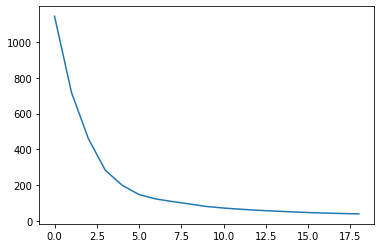

In [336]:
# Поиск лучшего числа кластеров через метрику inertia_

X_clust = X[:3000]

distortion = []
K = range(1, 20) 

# последовательно рассчитываем значения целевой функции по всем объектам с разным 
# количеством кластеров
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)   # определяем модель kMeans
    kmeans.fit(X_clust)   # применяем модель kMeans к выборке
    distortion.append(kmeans.inertia_) 

pd.Series(distortion).plot()

# При увеличении числа кластеров примерно больше 6, значительного улучшения качества не происходит. 
# Это соответсвует числу признаков. Его и оставляем.

<AxesSubplot:>

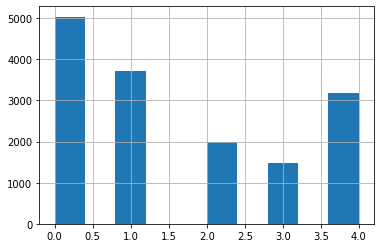

In [347]:
# Обучаем на той же или всей выборке
kmeans_text = KMeans(n_clusters=5, random_state=42)
kmeans_text.fit(X) # X_clust
# X['label_X'] = kmeans_text.labels_ # присваиваем каждому объекту номер его группы
Xy_clust['label_X5'] = kmeans_text.labels_ # присваиваем каждому объекту номер его группы

# Кол-во представителей каждого кластера 
# X['label_X'].hist()
Xy_clust['label_X5'].hist()



In [479]:
# Смотрим наибольшую концентрацию значений признаков по кластерам
X.groupby(['label_X']).median().style.background_gradient(cmap="Blues", axis=1)

,sadness,joy,love,anger,fear,surprise
label_X,,,,,,
0,0.019346,0.033725,0.010856,0.861582,0.028648,0.002996
1,0.014968,0.851543,0.033600,0.029632,0.005484,0.003193
2,0.906340,0.011362,0.005254,0.034833,0.006125,0.001547
3,0.053705,0.301047,0.041297,0.427657,0.038876,0.007599
4,0.006841,0.118105,0.755062,0.032993,0.004547,0.002705
5,0.023919,0.020375,0.007324,0.100177,0.682325,0.012527


#### По эмоциям звука 

<AxesSubplot:>

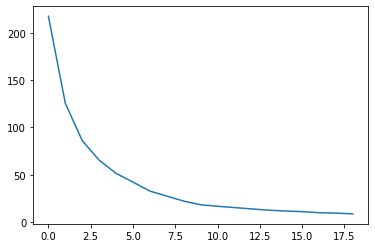

In [351]:
# Поиск лучшего числа кластеров через метрику inertia_

# По эмоциям песни
sound_emo_clust = text_sound_emo__Xy_clust[['anger_x', 'disgust', 'enthusiasm', 'fear_x', 'happiness', 'neutral', 'sadness_x', 'joy', 'love', 'surprise']]

# Смесь всех эмоций звука и текста    --> MAPE 24.8 (обучение на кластеры музыкальных признаков)
text_all_sound_emo_clust = text_all_sound_emo__Xy_clust[['anger_x', 'disgust', 'enthusiasm', 'fear_x', 'happiness', 'neutral',
                        'sadness_x', 'sadness_y', 'joy', 'love', 'anger_y', 'fear_y', 'surprise']]


distortion = []
K = range(1, 20) 

# последовательно рассчитываем значения целевой функции по всем объектам с разным 
# количеством кластеров
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)   # определяем модель kMeans
    kmeans.fit(sound_emo_clust)   # применяем модель kMeans к выборке
    distortion.append(kmeans.inertia_) 

pd.Series(distortion).plot()

# При увеличении числа кластеров примерно больше 6, значительного улучшения качества не происходит. 
# Это соответсвует числу признаков. Его и оставляем.

In [ ]:
# Обучаем на той же или всей выборке
kmeans_sound = KMeans(n_clusters=6, random_state=42)
kmeans_sound.fit(sound_emo_clust) # X_clust
Xy_clust['label_sound'] = kmeans_sound.labels_ # присваиваем каждому объекту номер его группы

# Кол-во представителей каждого кластера 
Xy_clust['label_sound'].hist()

### По музыкальным признакам

<AxesSubplot:>

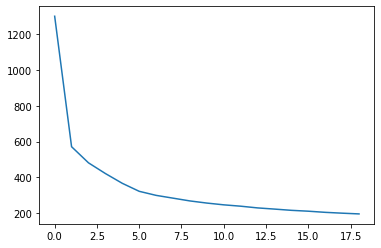

In [339]:
# поиск лучшего числа кластеров через метрику inertia_

y_clust = y[:3000]

distortion = []
K = range(1, 20) 

# последовательно рассчитываем значения целевой функции по всем объектам с разным 
# количеством кластеров
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)   # определяем модель kMeans
    kmeans.fit(y_clust)   # применяем модель kMeans к выборке
    distortion.append(kmeans.inertia_) 

pd.Series(distortion).plot()

# При увеличении числа кластеров примерно больше 6, значительного улучшения качества не происходит. 
# Это соответсвует числу признаков в нашей целевой переменной. Его и оставляем.

<AxesSubplot:>

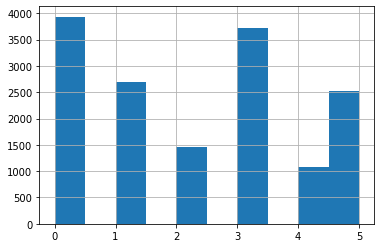

In [447]:
# делим на те де 6 групп, что и часть сета с эмоциями
# Обучаем 
kmeans_mus = KMeans(n_clusters=6, random_state=42)
kmeans_mus.fit(y) # _clust
y['label_y'] = kmeans_mus.labels_ # присваиваем каждому объекту номер его группы

# Кол-во представителей каждого кластера
y['label_y'].hist()

In [482]:
# Смотрим наибольшую концентрацию значений признаков по кластерам
# y.groupby(['label_y']).mean().style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1)


,danceability,energy,mode,acousticness,valence,tempo
label_y,,,,,,
0,0.522036,0.731254,1.000000,0.068585,0.348579,0.514518
1,0.668431,0.728152,1.000000,0.112568,0.717097,0.465348
2,0.520398,0.750635,0.000000,0.057721,0.351006,0.512018
3,0.705732,0.714546,0.000000,0.113234,0.713233,0.453751
4,0.597787,0.464397,0.000000,0.523116,0.407974,0.431264
5,0.535838,0.434100,1.000000,0.602905,0.393260,0.439901


## ОЙ

In [13]:
Xy_clust = pd.read_csv('Xy_clust.csv', index_col=0)

In [349]:
# Объединяем эмоциональный и музыкальный датасеты Группируем по кластерам эмоций и ...
# Удивляемся равномерности средних значений во второй (музыкальной) части объединенного датасета!

# Это свидетельствует о соответствии эмоциональных признаков музыкальным, что является залогом качественного обучения главной модели.
# Также из этого следует, что можно смело использовать центроиды кластеров (и соответствующих треков) 
# для запроса рекомендаций от Spotify.  

#Xy_clust = pd.concat([dfen[['track_name', 'track_artist', 'track_id']], X_clust, y_clust], axis = 1)
#Xy_clust = pd.concat([dfen[['track_name', 'track_artist', 'track_id']], X, y], axis = 1)
Xy_clust.groupby(['label_X']).mean().style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1)
# Xy_clust.groupby(['label_X5']).mean().style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1)

# Музыка -- это математика.
# Общий дом всех эмоций (может и "коллективное бессознательное" музыки) -- музыкальный кластер 2. Хотя он и небольшой. 
# Это подтверждает регрессионная линия на jointplot.
# Этот кластер отличают: энергичность, минорный лад, грусть.
# Относительно этого центра и будем оценивать , какие эмоции более точны: из текста, из песни вцелом, или из голосовой партии.
# Предсказывать кластер через регрессию, это, конечно издевательство над математикой. 
# Но. Регрессия из CastBoost CV при округлении предсказала тот самый кластер 2 почти для всех примеров с эмоциями! Константа, однако... 


,sadness,joy,love,anger,fear,surprise,danceability,energy,mode,acousticness,valence,tempo,label_y,label_X5
label_X,,,,,,,,,,,,,,
0,0.036563,0.056210,0.020408,0.838549,0.044406,0.003863,0.626428,0.693326,0.580516,0.146694,0.505406,0.479748,1.769473,0.028553
1,0.028694,0.819773,0.071410,0.064584,0.010603,0.004936,0.597025,0.686263,0.602863,0.170475,0.537936,0.477611,1.884086,1.000842
2,0.840218,0.040416,0.016180,0.080372,0.020068,0.002746,0.550774,0.680049,0.591208,0.183712,0.473982,0.482024,1.903992,2.004042
3,0.111623,0.297034,0.088393,0.411451,0.069034,0.022464,0.585141,0.693194,0.599259,0.166569,0.519356,0.481753,1.799461,3.420290
4,0.018775,0.166712,0.731783,0.068545,0.009839,0.004346,0.600951,0.644405,0.581570,0.202845,0.549594,0.464131,2.086689,3.000683
5,0.054763,0.041710,0.015420,0.136259,0.682751,0.069097,0.588499,0.665813,0.597305,0.187511,0.494243,0.471275,1.983533,3.988024


In [557]:
Xy_clust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15405 entries, 0 to 15404
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   track_name    15405 non-null  object 
 1   track_artist  15405 non-null  object 
 2   track_id      15405 non-null  object 
 3   sadness       15405 non-null  float64
 4   joy           15405 non-null  float64
 5   love          15405 non-null  float64
 6   anger         15405 non-null  float64
 7   fear          15405 non-null  float64
 8   surprise      15405 non-null  float64
 9   label_X       15405 non-null  int64  
 10  danceability  15405 non-null  float64
 11  energy        15405 non-null  float64
 12  mode          15405 non-null  float64
 13  acousticness  15405 non-null  float64
 14  valence       15405 non-null  float64
 15  tempo         15405 non-null  float64
 16  label_y       15405 non-null  int64  
dtypes: float64(12), int64(2), object(3)
memory usage: 2.6+ MB


In [14]:
# Xy_clust.drop(['track_name', 'track_artist', 'track_id'], axis=1)#.groupby(['label_X']).mode().style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1)
Xy_clust[Xy_clust['label_X'] == 1].sample(3)

,track_name,track_artist,track_id,sadness,joy,love,anger,fear,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
5718,Engineers,Hp Boyz,2WKAty6EEiV8Lt8dAnRAdy,0.034794,0.772519,0.040748,0.134775,0.012729,0.004435,1,0.947856,0.391844,1.0,0.308467,0.308772,0.359039,5
1361,It's So Hard To Say Goodbye To Yesterday - Ori...,Boyz II Men,0QVCqacAloq7NsnPWhW3Pk,0.101659,0.729762,0.052427,0.104399,0.008699,0.003054,1,0.209733,0.083291,1.0,0.931452,0.299690,0.542826,5
10291,Georgia,Brittany Howard,5bTaLbpRK8aJvqf2xHlwa7,0.003920,0.856740,0.125481,0.011325,0.001539,0.000995,1,0.293163,0.541340,1.0,0.516128,0.248227,0.311188,5


In [350]:
Xy_clust.groupby(['label_X5']).mean().style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1)

,sadness,joy,love,anger,fear,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
label_X5,,,,,,,,,,,,,,
0,0.040186,0.064419,0.022754,0.826040,0.042615,0.003987,0.183443,0.625266,0.694103,0.584872,0.146826,0.506146,0.478822,1.762954
1,0.029805,0.808914,0.071699,0.073139,0.011357,0.005086,1.081852,0.596664,0.686479,0.605008,0.169859,0.537859,0.479121,1.874260
2,0.839024,0.040611,0.016200,0.080978,0.020435,0.002752,2.009567,0.550360,0.680335,0.591138,0.183968,0.473763,0.482803,1.903827
3,0.018745,0.166864,0.728390,0.071755,0.009894,0.004352,3.987854,0.601104,0.643594,0.582996,0.202861,0.549751,0.464437,2.085020
4,0.102716,0.240185,0.073991,0.343953,0.204721,0.034434,3.383239,0.584166,0.686778,0.590395,0.172593,0.513331,0.479095,1.857502


In [346]:
Xy_clust.groupby(['label_y']).mean().style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1)

,sadness,joy,love,anger,fear,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo
label_y,,,,,,,,,,,,,
0,0.173743,0.268450,0.090176,0.391227,0.066205,0.010199,1.594841,0.522036,0.731254,1.000000,0.068585,0.348579,0.514518
1,0.120878,0.305917,0.126890,0.376710,0.059245,0.010359,1.676067,0.668431,0.728152,1.000000,0.112568,0.717097,0.465348
2,0.176822,0.274224,0.088898,0.384875,0.064570,0.010610,1.614410,0.520398,0.750635,0.000000,0.057721,0.351006,0.512018
3,0.118587,0.303052,0.120540,0.390496,0.057884,0.009442,1.620920,0.705732,0.714546,0.000000,0.113234,0.713233,0.453751
4,0.166446,0.262918,0.143803,0.353092,0.063636,0.010105,1.819795,0.597787,0.464397,0.000000,0.523116,0.407974,0.431264
5,0.183890,0.293944,0.130445,0.311818,0.066986,0.012917,1.851444,0.535838,0.434100,1.000000,0.602905,0.393260,0.439901


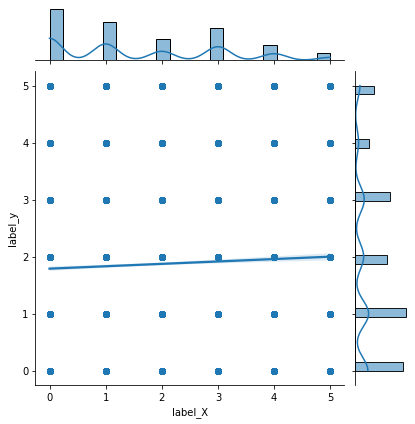

In [485]:
# Центральный Музыкальный кластер 2 подтвержден регрессионной линией
sns.jointplot(data=Xy_clust, x="label_X", y="label_y", kind="reg")  # , hue=dfen.playlist_genre, kind="kde"  , kind="reg"

In [359]:
Xy_clust.corr().style.background_gradient(cmap="coolwarm", axis=None)

,sadness,joy,love,anger,fear,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
sadness,1.000000,-0.317664,-0.201660,-0.325631,-0.101077,-0.060537,0.126362,-0.129417,-0.005070,0.004238,0.026975,-0.088792,0.013219,0.005790
joy,-0.317664,1.000000,-0.070328,-0.525773,-0.226046,-0.058859,-0.067188,-0.001173,0.008386,0.006110,0.005698,0.074896,-0.002407,0.010783
love,-0.201660,-0.070328,1.000000,-0.332533,-0.144348,-0.039240,0.498444,0.010718,-0.079585,0.001481,0.062925,0.065012,-0.025614,0.051462
anger,-0.325631,-0.525773,-0.332533,1.000000,-0.065839,-0.090741,-0.555669,0.109199,0.049088,-0.013436,-0.069924,-0.026172,0.011117,-0.047433
fear,-0.101077,-0.226046,-0.144348,-0.065839,1.000000,0.139250,0.419139,-0.021656,-0.003248,0.005856,0.006880,-0.030662,-0.004733,-0.001375
surprise,-0.060537,-0.058859,-0.039240,-0.090741,0.139250,1.000000,0.166021,-0.013208,-0.009800,0.005967,0.004307,-0.000818,-0.008705,0.006952
label_X,0.126362,-0.067188,0.498444,-0.555669,0.419139,0.166021,1.000000,-0.077098,-0.050611,0.006044,0.064313,0.015680,-0.015878,0.040436
danceability,-0.129417,-0.001173,0.010718,0.109199,-0.021656,-0.013208,-0.077098,1.000000,-0.112729,-0.071603,-0.047142,0.335398,-0.212693,0.071920
energy,-0.005070,0.008386,-0.079585,0.049088,-0.003248,-0.009800,-0.050611,-0.112729,1.000000,-0.010438,-0.562406,0.201555,0.156872,-0.440414
mode,0.004238,0.006110,0.001481,-0.013436,0.005856,0.005967,0.006044,-0.071603,-0.010438,1.000000,0.027226,-0.002135,0.025511,-0.478024


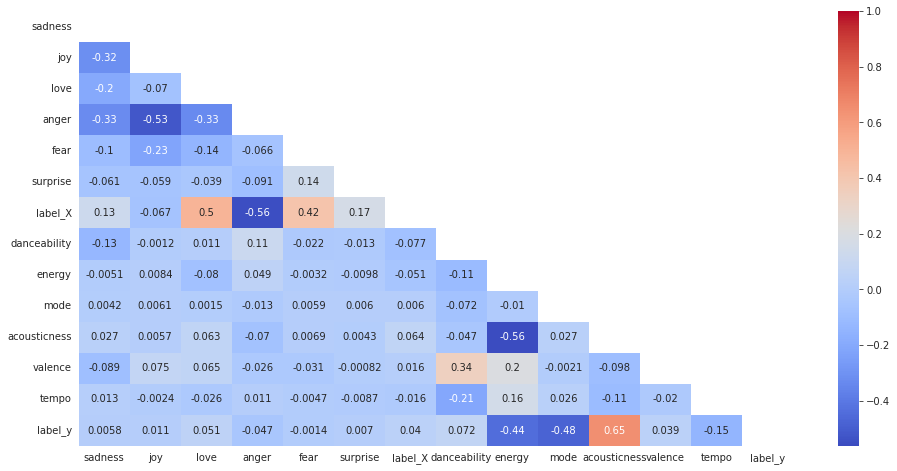

In [487]:
mask = np.zeros_like(Xy_clust.corr())
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16, 8))
    ax = sns.heatmap(Xy_clust.corr(), mask=mask, vmax=1, square=False, cmap = 'coolwarm', annot = True)

In [526]:
# Сохраняем сет
# Xy_clust.to_csv('Xy_clust.csv')

## По новому тексту

### кластеризация эмоций

In [34]:
# Создание и сохраниение модели кластеризации

import pandas as pd
from sklearn.cluster import KMeans
import pickle

text_emos_set = pd.read_csv('text_emos.csv', index_col=[0])


# Обучаем на всей выборке
kmeans_text = KMeans(n_clusters=6, random_state=42)
kmeans_text.fit(text_emos_set) # X_clust

# save the model
pickle.dump(kmeans_text, open("./models/kmeans_text.pkl", "wb"))

# load the model
#kmeans_text = pickle.load(open("./models/kmeans_text.pkl", "rb"))


KMeans(n_clusters=6, random_state=42)

In [ ]:

import tqdm
from collections import Counter
import torch
print('torch   :', torch.__version__)


import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
print('tensorflow   :', tf.__version__)


import random

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import pipeline
from transformers import AutoTokenizer


import pandas as pd
from sklearn.cluster import KMeans
import pickle


text_emo_model = pipeline("sentiment-analysis", model='./albert-base-v2-emotion', return_all_scores=True)
#text_emo_pred = text_emo_model("I love using transformers. The best part is wide range of support and its easy to use", )

In [59]:


# text_to_predict = "I'm very sad today, I want someone to be there for me, and I really need someone to love me. "
text_to_predict = "I'm so sad, I'm crying. Tears are flowing in torrents"
# text_to_predict = "I'm so sad, I'm crying 'cause his dog's not dying."
print(text_to_predict)


text_emos_pred = text_emo_model(text_to_predict)
text_emos = pd.DataFrame.from_dict(text_emos_pred[0]).set_index('label').T.reset_index(drop=True)
display(text_emos.style.background_gradient(cmap="Blues", axis=1))


# load the CLUST model
kmeans_text = pickle.load(open("./models/kmeans_text.pkl", "rb"))

text_emos_cluster = kmeans_text.predict(text_emos)
print('text_emos_cluster:', text_emos_cluster)


# Отсюда будем брать песни для рекомендаций
Xy_clust = pd.read_csv('Xy_clust.csv', index_col=0)

# Рекомендации без предсказания музыкальных признаков и сужения по кластеру полученного предсказания
display(Xy_clust[Xy_clust['label_X'] == text_emos_cluster[0,]].sample(3).style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1))



I'm so sad, I'm crying. Tears are flowing in torrents


label,sadness,joy,love,anger,fear,surprise
0,0.817341,0.003001,0.003693,0.101448,0.072578,0.001938


text_emos_cluster: [2]


,track_name,track_artist,track_id,sadness,joy,love,anger,fear,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
1366,Twenty Something - Stripped Sessions,Nightly,0qxRmtTovuLU4VBz5y4DsJ,0.928234,0.003261,0.003764,0.063021,0.001289,0.000432,2,0.558517,0.419302,1.000000,0.107862,0.057306,0.358919,0
10758,314 (feat. Night Lovell),Dylan Brady,5jAeM4WKpqDX9wDJGa7IFq,0.972192,0.003430,0.005304,0.016979,0.001520,0.000575,2,0.623407,0.408116,1.000000,0.053325,0.131172,0.336379,0
8292,5AM,Amber Run,4B4kunXhV2ZKnYcvDgAFoE,0.990695,0.002018,0.000918,0.003433,0.002328,0.000609,2,0.279258,0.424387,1.000000,0.245967,0.091515,0.620656,0


In [96]:
text_emos.T.max()[0], text_emos.T.idxmax()[0]

(0.8173414468765259, 'sadness')

In [48]:
# Для бота, вывод распознанных эмоций

print(f"Вот как я тебя услышал: \n\
{'😁'*(1+round(text_emos.joy[0]*10))} \n\
{'😔'*(1+round(text_emos.sadness[0]*10))} \n\
{'🥰'*(1+round(text_emos.love[0]*10))} \n\
{'😠'*(1+round(text_emos.anger[0]*10))} \n\
{'😨'*(1+round(text_emos.fear[0]*10))} \n\
{'😲'*(1+round(text_emos.surprise[0]*10))}")


Вот как я тебя услышал: 
😁😁😁😁😁😁😁😁😁😁 
😔 
🥰 
😠 
😨 
😲


In [54]:
print(f"Вот как я тебя услышал: \n\
{'😁'*(1+round(text_emos.joy[1]*10))} \n\
{'😔'*(1+round(text_emos.sadness[1]*10))} \n\
{'🥰'*(1+round(text_emos.love[1]*10))} \n\
{'😠'*(1+round(text_emos.anger[1]*10))} \n\
{'😨'*(1+round(text_emos.fear[1]*10))} \n\
{'😲'*(1+round(text_emos.surprise[1]*10))}")

Вот как я тебя услышал: 
😁😁 
😔 
🥰 
😠😠😠 
😨😨😨😨😨😨😨 
😲


### на музыкальные признаки

In [76]:
# Создание и сохраниение модели кластеризации


mus_feats = Xy_clust[['danceability', 'energy', 'mode', 'acousticness', 'valence', 'tempo']]

kmeans_mus = KMeans(n_clusters=6, random_state=42)
kmeans_mus.fit(mus_feats)

pickle.dump(kmeans_mus, open("./models/kmeans_mus.pkl", "wb"))

In [60]:

# Отсюда будем брать песни для рекомендаций
#Xy_clust = pd.read_csv('Xy_clust.csv', index_col=0)

from catboost import cv, CatBoostRegressor

# загрузка лучшей модели предскзаний по эмоциям текста
text_emo__mus_clust = CatBoostRegressor()
# text_emo__mus_clust = cv()
text_emo__mus_clust.load_model("./models/text_emo__mus_feats", format='cbm')

# load the clust model
kmeans_mus = pickle.load(open("./models/kmeans_mus.pkl", "rb"))

'''
text_to_predict = '"Seasons change and our love went cold \
    Feed the flame 'cause we can't let go \
    Run away, but we're running in circles \
    Run away, run away \
    I dare you to do something \
    I'm waiting on you again \
    So I don't take the blame \
    Run away, but we're running in circles \
    Run away, run away, run away"'



text_emos_pred = text_emo_model(text_to_predict)
text_emos = pd.DataFrame.from_dict(text_emos_pred[0]).set_index('label').T.reset_index(drop=True)
display(text_emos.style.background_gradient(cmap="Blues", axis=1))
'''

# mus_feats_cb = cb.predict(text_emos) # text_sound_emos  text_emos
mus_feats_cb = text_emo__mus_clust.predict(text_emos) # text_sound_emos  text_emos
print('mus_feats_cb_pred:')
display(pd.DataFrame(mus_feats_cb, columns=mus_feats.columns).style.background_gradient(cmap="Blues", axis=1))

mus_feats_cluster = kmeans_mus.predict(mus_feats_cb)
print('mus_feats_cluster:', mus_feats_cluster)
# print('centroid_mus_feats:')
# centroid_mus_feats = kmeans_mus.cluster_centers_[mus_feats_cluster]
# display(pd.DataFrame(centroid_mus_feats, columns=y.columns).style.background_gradient(cmap="Blues", axis=1))


# Находим представителей пересечения кластеров эмуций текста и музыкальных признаков
display(Xy_clust[(Xy_clust['label_y'] == mus_feats_cluster[0,]) & (Xy_clust['label_X'] == text_emos_cluster[0,])].sample(10).style.background_gradient(cmap="Blues", axis=None, vmin=0, vmax=1))

mus_feats_cb_pred:


,danceability,energy,mode,acousticness,valence,tempo
0,0.513056,0.736557,0.419971,0.184229,0.449000,0.524571


mus_feats_cluster: [5]


d:\DS\Base\Python310\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


,track_name,track_artist,track_id,sadness,joy,love,anger,fear,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
12285,Music,Leela James,6Cl90cl4efMaG05Xm4LjDN,0.799593,0.088730,0.021939,0.080609,0.006897,0.002232,2,0.767092,0.629818,1.000000,0.505040,0.524718,0.347920,5
6368,Remember the Rain,Kadhja Bonet,3bPlMzfHJMYqdAC80NLPTb,0.909934,0.009398,0.006207,0.068762,0.004443,0.001256,2,0.466976,0.391844,1.000000,0.745967,0.514627,0.565343,5
11656,Now,Miguel,5XN9jwDlXAZ8j5nMcK7S1d,0.626660,0.252818,0.018197,0.078157,0.019764,0.004405,2,0.388181,0.509814,1.000000,0.721774,0.414727,0.426875,5
2570,Mary Go Round,Musiq Soulchild,1DTRyqSQ6CfDs46Ft9vUpR,0.976473,0.004672,0.003958,0.013479,0.000887,0.000531,2,0.507532,0.463033,1.000000,0.307459,0.501509,0.595173,5
4364,Georgia,Kevin Abstract,2B15MgKTaavdlKdlwd4W0R,0.716511,0.022479,0.135277,0.098166,0.024961,0.002606,2,0.634994,0.513882,1.000000,0.734879,0.291617,0.553830,5
6719,This City,Sam Fischer,3H3r2nKWa3Yk5gt8xgmsEt,0.952459,0.005547,0.015295,0.019947,0.005846,0.000906,2,0.563152,0.366419,1.000000,0.736895,0.522700,0.210047,5
8046,Burning House (feat. Aaron Krause),EZA,448kqm1gUbI2qmu2Fh5uz8,0.734583,0.041472,0.049914,0.082605,0.083453,0.007974,2,0.381228,0.405065,1.000000,0.479838,0.151354,0.562760,5
8805,Shannon,Henry Gross,4IYoyOVK9oQyJS1QZt5Vyj,0.863519,0.041860,0.055694,0.034049,0.003383,0.001494,2,0.512167,0.349130,1.000000,0.231854,0.513618,0.289813,5
5346,The Root,D'Angelo,2Qmkg3JVW6e0w55HQudjSW,0.891612,0.009209,0.008916,0.080208,0.007693,0.002362,2,0.869061,0.399980,1.000000,0.502015,0.710391,0.246139,5
12272,You Take My Breath Away - Remastered 2011,Queen,6CD2NyrQ5rHmik1DjhdDdn,0.692997,0.037959,0.017895,0.234822,0.014217,0.002110,2,0.136732,0.199634,1.000000,0.959677,0.079405,0.857327,5


## Создаем датасет для рекомендаций

In [ ]:
recoms_Xy_clust = Xy_clust[(Xy_clust['label_y'] == mus_feats_cluster[0,]) & (Xy_clust['label_X'] == text_emos_cluster[0,])].sample(10)
display(recoms_Xy_clust)

recoms_Xy_clust_list = recoms_Xy_clust[['track_artist', 'track_name']].to_list()
recoms_Xy_clust_list


In [72]:
titles_list = recoms_Xy_clust[['track_artist', 'track_name']].to_string(header=False, index=False, index_names=False).split('\n')  # \n
# titles_list = [' '.join(el.split()) for el in titles_list]
# print(titles_list)
titles_list

['         Sampha                                      Incomplete Kisses',
 '  Lewis Capaldi                                                Bruises',
 '  Dionne Farris Hopeless (From the New Line Cinema Film, "Love Jones")',
 "        The Who                         Baba O'Riley - Remixed Version",
 'Musiq Soulchild                                          Mary Go Round',
 '      Oh Wonder                                          Midnight Moon',
 '    Matt Maeson                                      Cringe - Stripped',
 '    Jon Bellion                                      Carry Your Throne',
 '       Lil Tjay                                                  20/20',
 ' Gloria Estefan                                       Anything for You']

In [68]:
titles_df

['         Sampha                                      Incomplete Kisses',
 '  Lewis Capaldi                                                Bruises',
 '  Dionne Farris Hopeless (From the New Line Cinema Film, "Love Jones")',
 "        The Who                         Baba O'Riley - Remixed Version",
 'Musiq Soulchild                                          Mary Go Round',
 '      Oh Wonder                                          Midnight Moon',
 '    Matt Maeson                                      Cringe - Stripped',
 '    Jon Bellion                                      Carry Your Throne',
 '       Lil Tjay                                                  20/20',
 ' Gloria Estefan                                       Anything for You']

In [63]:
for index, row in recoms_Xy_clust[['track_artist', 'track_name']].iterrows():


,track_artist,track_name
9212,Sampha,Incomplete Kisses
9143,Lewis Capaldi,Bruises
5780,Dionne Farris,"Hopeless (From the New Line Cinema Film, ""Love..."
11527,The Who,Baba O'Riley - Remixed Version
2570,Musiq Soulchild,Mary Go Round
13477,Oh Wonder,Midnight Moon
13411,Matt Maeson,Cringe - Stripped
12919,Jon Bellion,Carry Your Throne
8724,Lil Tjay,20/20
6373,Gloria Estefan,Anything for You


In [406]:
# Близость к центру
np.correlate(mus_feats_cb.flatten(), centroid_mus_feats.flatten())

array([1.88057143])

In [451]:
# представители кластера
Xy_clust[Xy_clust['label_X'] == mus_feats_cluster[0,]].sample(3).style.background_gradient(cmap="Blues", axis=1)

,track_name,track_artist,track_id,sadness,joy,love,anger,fear,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
2828,Waves,Luna Shadows,1hsPZY6oWcPfFPqDEQmMaW,0.139611,0.382977,0.046431,0.354378,0.066305,0.010298,0.000000,0.519119,0.823045,0.000000,0.177418,0.420781,0.484908,5.000000
520,Blaze It up (feat. Sparkz),The Mouse Outfit,0DJBgfyaAlT7T0i0YAuzrS,0.176681,0.494828,0.048204,0.250954,0.023334,0.006000,0.000000,0.841251,0.464050,0.000000,0.594757,0.655900,0.313622,1.000000
2257,Photograph,Def Leppard,18URo35acNKRTHfEdjTcGn,0.059698,0.295542,0.137220,0.452517,0.048209,0.006814,0.000000,0.563152,0.874911,1.000000,0.000344,0.622600,0.494592,3.000000


In [495]:
Xy_clust[Xy_clust['label_y'] == mus_feats_cluster[0,]].sample(5)[['track_id', 'track_name', 'track_artist', 'label_X', 'label_y']]

,track_id,track_name,track_artist,label_X,label_y
2313,1AEBHsada30zIIiWnAvHb3,Back To You - Anki Remix,Selena Gomez,2,0
9094,4npV4yaAqVv62cSIWmPEbf,Look Away - Steve Void Remix,Stephen Puth,5,0
14094,78W3OjLt8Ugxaar3h9mY2j,Good Morning,John Legend,4,0
14335,7d7nFnedVJnEeeGMMNhyKC,Run To The Hills,Iron Maiden,0,0
6709,3gz9yz2nmD3vpxWRYqZJ2B,Platinum Hearts - Suspect 44 Radio Edit,Breathe Carolina,3,0


# Bot 

### Загрузка представителей кластеров

In [5]:
import pandas as pd
Xy_clust = pd.read_csv('Xy_clust.csv', index_col=0) # , engine='python'
Xy_clust.sample(1)

,track_name,track_artist,track_id,sadness,joy,love,anger,fear,surprise,label_X,danceability,energy,mode,acousticness,valence,tempo,label_y
4682,TOES (feat. Lil Baby & Moneybagg Yo),DaBaby,2FvD20Z8aoWIePi7PoN8sG,0.030775,0.003227,0.00374,0.944657,0.016686,0.000917,0,0.811124,0.574901,1.0,0.080039,0.546918,0.702136,1


In [23]:
from pyrogram import Client
from pyrogram import filters
from pyrogram.types import (
    ReplyKeyboardMarkup, InlineKeyboardMarkup, InlineKeyboardButton)

import time
from time import localtime, strftime
import random

from pytube import Channel
from pytube import YouTube
from pytube.cli import on_progress
from pytube import Search


app = Client(
    "Download YouTube MP3",
    api_id=19375155, 
    api_hash="4ceeb***",
    workers = 5, 
    bot_token ='5341947977***'
#    phone_number ='+7***'
)




def DownloadYouTubeMP3_list(url, path, Filename):
    if not os.path.exists(path):
        os.makedirs(path)
   
    yt = YouTube(url, on_progress_callback=on_progress)
    print(f'  ⏳ Работаем над "{yt.title}"')

    audio_only = yt.streams.get_audio_only()
    audio_only.download(path, 
        filename = Filename, # audio_only.default_filename.replace('mp4','mp3'), 
        skip_existing=True)
    print('    👌🔊 Готово!')
    #print('    ', yt.author  + ' -- ' + yt.title)



# Список песен на закачку
mus_list = pd.DataFrame()

#cluster_num = 0
for cluster_num in Xy_clust['label_y'].unique()[:]:
    # список ссылок кластера
    urls = []

    mus_list_clust = Xy_clust[Xy_clust['label_y'] == cluster_num].sample(2)[['track_id', 'track_name', 'track_artist', 'label_X', 'label_y']]
    print('cluster_num', cluster_num)

    for track_num in range(len(mus_list_clust)):
        
        # Ищем в YouTube
        yts = Search(f'{mus_list_clust.track_artist.iloc[track_num]} -- {mus_list_clust.track_name.iloc[track_num]}')
        url = yts.results[0].watch_url

        # ЗАПУСКАЕМ загрузку 
        DownloadYouTubeMP3_list(url, 'D:\DNS\Downloads\mus_list', f'{mus_list_clust.track_id.iloc[track_num]}.mp3')

        # Записываем url в список 
        urls.append(url)

        time.sleep(5 + random.randint(0,10))

    # Присоединяем список ссылок к сету
    mus_list_clust['url'] = urls

    mus_list = mus_list.append(mus_list_clust)

mus_list.to_csv('mus_list.csv')


cluster_num 0
  ⏳ Работаем над "Magic Man - Paris (Official)"
    👌🔊 Готово!████████████████████████████████| 100.0%
  ⏳ Работаем над "PETE TOWNSHEND - Give Blood"
    👌🔊 Готово!████████████████████████████████| 100.0%


C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2817576233.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


cluster_num 3
  ⏳ Работаем над "Raekwon - Heaven & Hell (Official HD Video) ft. Ghostface Killah"
    👌🔊 Готово!████████████████████████████████| 100.0%
  ⏳ Работаем над "Mura Masa, NAO - Complicated"
    👌🔊 Готово!████████████████████████████████| 100.0%


C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2817576233.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


cluster_num 4
  ⏳ Работаем над "GoldLink - Spectrum (GEOTHEORY Remix) [Audio]"
    👌🔊 Готово!████████████████████████████████| 100.0%
  ⏳ Работаем над "Jorja Smith - Teenage Fantasy (Official Video)"
    👌🔊 Готово!████████████████████████████████| 100.0%


C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2817576233.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


cluster_num 5


Unexpected renderer encountered.
Renderer name: dict_keys(['reelShelfRenderer'])
Search term: Gloria Estefan -- Coming Out of the Dark
Please open an issue at https://github.com/pytube/pytube/issues and provide this log output.


  ⏳ Работаем над "Coming Out Of The Dark"
    👌🔊 Готово!████████████████████████████████| 100.0%
  ⏳ Работаем над "Future - Low Life (Official Music Video) ft. The Weeknd"
    👌🔊 Готово!████████████████████████████████| 100.0%


C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2817576233.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


cluster_num 1
  ⏳ Работаем над "Mabel - Don't Call Me Up (Burak Yeter Remix)"
    👌🔊 Готово!████████████████████████████████| 100.0%
  ⏳ Работаем над "Sia - The Greatest"
    👌🔊 Готово!████████████████████████████████| 100.0%


C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2817576233.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


cluster_num 2
  ⏳ Работаем над "Lisa LeBlanc - Ace of Spades"
    👌🔊 Готово!████████████████████████████████| 100.0%
  ⏳ Работаем над "Leonell Cassio - Lying We're Fine (ft. Sarah Hemi) [Free To Use/Copyright Free] 🐍"
    👌🔊 Готово!████████████████████████████████| 100.0%


C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2817576233.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


In [25]:
# Сохраняем
# mus_list.to_csv('mus_list.csv')

In [22]:
mus_list

,track_id,track_name,track_artist,label_X,label_y,url
12623,6hu1f1cXSw7OAqhpSQ2zDy,Dazed and Confused,Led Zeppelin,5,0,https://youtube.com/watch?v=w772GXG5LnE
14686,7iT98FhZ7BAE8xdCxBlw55,Take Me Home (feat. Bebe Rexha),Cash Cash,0,0,https://youtube.com/watch?v=kDo2SiW3JHU
9580,4VckRQW4RhwwIx6p8HSAbE,Lighthouse,Sam Padrul,3,3,https://youtube.com/watch?v=eC9Nvs1HlGY
5791,2Xo3rLHjXfdb4avN68aQyi,BEST ON EARTH (feat. BIA),Russ,0,3,https://youtube.com/watch?v=uTM0IPt2PTs
4943,2k9N4caeCIJLOWwWwssrEM,Easily,Bruno Major,3,4,https://youtube.com/watch?v=sRJ4RywOPvA
11024,5nKEBGtC5ORYnZMeOacpxG,Want It,Emmit Fenn,3,4,https://youtube.com/watch?v=r30b-rWJw5Y
4416,2BPjarKTt9Gbjf5Z9iMACP,Rising Sun,George Harrison,2,5,https://youtube.com/watch?v=L44YmN4NsoA
6931,3Ko8zjBg7VtcPTVnd5awJM,The Christmas Song,Nat King Cole,1,5,https://youtube.com/watch?v=wKhRnZZ0cJI
32,01DSvNTUsVROjnSF5j3UbD,Try,P!nk,0,1,https://youtube.com/watch?v=yTCDVfMz15M
10596,5GoYN20kgpNbgl5IFf8WHx,Hit and Run,Midnght,2,1,https://youtube.com/watch?v=pFC9LWt6gBM


In [20]:
for cluster_num in Xy_clust['label_y'].unique()[:]:
    urls = []
    mus_list_clust = Xy_clust[Xy_clust['label_y'] == cluster_num].sample(2)[['track_id', 'track_name', 'track_artist', 'label_X', 'label_y']]
    print('cluster_num', cluster_num)

    for track_num in range(len(mus_list_clust)):
        
        # Ищем в YouTube
        yts = Search(f'{mus_list_clust.track_artist.iloc[track_num]} -- {mus_list_clust.track_name.iloc[track_num]}')
        url = yts.results[0].watch_url

        # ЗАПУСКАЕМ загрузку 
        #DownloadYouTubeMP3_list(url, 'D:\DNS\Downloads\mus_list', f'{mus_list_clust.track_id.iloc[track_num]}.mp3')

        # Записываем url в список 
        urls.append(url)

        time.sleep(5 + random.randint(0,10))

    # Присоединяем список ссылок к сету
    mus_list_clust['url'] = urls

    mus_list = mus_list.append(mus_list_clust)

cluster_num 0


C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2222799081.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


cluster_num 3


C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2222799081.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


cluster_num 4


Unexpected renderer encountered.
Renderer name: dict_keys(['reelShelfRenderer'])
Search term: Emmit Fenn -- Want It
Please open an issue at https://github.com/pytube/pytube/issues and provide this log output.
C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2222799081.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


cluster_num 5


C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2222799081.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


cluster_num 1


Unexpected renderer encountered.
Renderer name: dict_keys(['showingResultsForRenderer'])
Search term: Midnght -- Hit and Run
Please open an issue at https://github.com/pytube/pytube/issues and provide this log output.
C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2222799081.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


cluster_num 2


C:\Users\AK\AppData\Local\Temp/ipykernel_37512/2222799081.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


In [9]:
Xy_clust['label_y'].unique()[2:]

array([4, 5, 1, 2], dtype=int64)

In [ ]:
cluster_num = 1
mus_feats_cluster[cluster_num,]

In [510]:
Xy_clust['label_y'].unique()

array([0, 3, 4, 5, 1, 2])

In [508]:
mus_list = mus_list.append(mus_list_clust)

C:\Users\AK\AppData\Local\Temp/ipykernel_15272/3792937973.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mus_list = mus_list.append(mus_list_clust)


In [509]:
mus_list

,track_id,track_name,track_artist,label_X,label_y,url
14895,7M2t0mMSjLJSweu8BwrY2R,Wakanda,Dimitri Vegas & Like Mike,0,2,https://youtube.com/watch?v=3A2Hpl1f-EU
3430,1qiTvDvaUqfpTKopOfby8h,Biggest Joke Of All,Fatima,0,4,https://youtube.com/watch?v=jA4ZkAFOaV8
5740,2wWboDFZJPWXVNlHUbdSVQ,Dear No One,Tori Kelly,0,0,https://youtube.com/watch?v=njmCUJ94lUM


In [472]:
mus_list.iloc[0]['url'] = url

C:\Users\AK\AppData\Local\Temp/ipykernel_15272/2218656689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mus_list.iloc[0]['url'] = url
C:\Users\AK\AppData\Local\Temp/ipykernel_15272/2218656689.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mus_list.iloc[0]['url'] = url


In [68]:
from pydub import AudioSegment

# short = librosa.load('0fIFjeeLJjIBliWUCsxyMF.wav', sr=16000, offset=-60) # D:/DNS/Downloads/mus_list/
#short = AudioSegment.from_file('D:\DNS\Downloads\mus_list\1Mw433bxzwrR1boiIcovdZ.mp3', format="mp4")
short = AudioSegment.from_file('1Mw433bxzwrR1boiIcovdZ.wav')[-120000:-60000]
#short = AudioSegment.from_file('1Mw433bxzwrR1boiIcovdZ.mp3', format="mp4")

short.export('_1Mw433bxzwrR1boiIcovdZ.wav')

<_io.BufferedRandom name='_1Mw433bxzwrR1boiIcovdZ.wav'>

In [ ]:
filename = '1Mw433bxzwrR1boiIcovdZ'
short.export(f'D:/DNS/Downloads/mus_list/mus_list/short/{filename}.wav')

# Translation

In [131]:
%pip install googletrans==4.0.0rc1

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17416 sha256=85e36a652a82a03b069eee6a15185ae8b6ceff922c21acd2a8809c0f15b25353
  Stored in directory: c:\users\ak\appdata\local\pip\cache\wheels\c0\59\9f\7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: googletrans
    Found existing installation: googletrans 3.0.0
    Uninstalling googletrans-3.0.0:
      Successfully uninstalled googletrans-3.0.0
Note: you may need to restart the kernel to use updated packages.


In [10]:
from googletrans import Translator
translator = Translator()

# source_text = 'In a world where the ailment sinful torments the suffering people close to the abyss of the bottomless in the wind now standing'
source_text = 'В мире где недуг греховный мучает страждущих людей близко к пропасти бездонной на ветру стою теперь'
translator.translate(source_text).text  # , src='ru', dest='en'
# translator.translate('안녕하세요.').text

'In a world where the ailment sinful torments the suffering people close to the abyss of the bottomless in the wind now standing'

# Spotify

In [1]:
%pip uninstall spotify

^C
Note: you may need to restart the kernel to use updated packages.


In [1]:
import spotipy

urn = 'spotify:artist:3jOstUTkEu2JkjvRdBA5Gu'
sp = spotipy.Spotify()

artist = sp.artist(urn)
print(artist)

user = sp.user('plamere')
print(user)

ModuleNotFoundError: No module named 'spotipy'